# Time Series classification of Aerodynamics
The boundary layer on an airfoil can be in two states, Laminar or Turbulent. Visually this switch is quite easy to see, for the aerodynamics muggles, the turbulent boundary layer state with show up on the time series data from the microphone as very turbulent(or volatile if you are from the finance world). 
Other ways to solve this problem include
- Traditional signal processing tricks that can extract such a change over of course. 
- Bayesian switch point analysis with a flexible number of switch points would also work. 
- The auto-regressive type models<br>
But I wanted to try my hand at getting a time series model in torch working, so here we are. 

In [1]:
import torch 
import pickle
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.utils.data
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from matplotlib import animation, rc
rc('animation', html='jshtml')
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Set up Model
One layer LSTM to multi layer fully conencted.
Sigmoid on the out layer as it is a classification problem. 
More layers can be enabled but 91% Validation error is possible with our the second lstm and extra fc layers. 

In [2]:
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(Classifier, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
        
        self.Sig = nn.Sigmoid()
        
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))

    def forward(self, input):
        
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        #input.view(self.input_dim, self.batch_size, -1)
        lstm_out, self.hidden = self.lstm(input.view(-1,len(input),6))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = self.Sig(self.linear(lstm_out[-1].view(len(input), -1)))
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)


# Read in data
The features of the time series have been pre-processed to include the time series itself and the first 5 mel-spectrum coefficients. 
!!! Need to double check for data leakage in the mel-spectrum coefficients 

In [3]:
df = pd.read_pickle("Reduced.pkl")
Split = 0.8
SplitInd = int(Split * len(df))
LabelList = ['ts',*range(5)]
Input = torch.tensor(df[LabelList].values)
Output = torch.tensor(df['Labels'].values)

#load second file hacky way for now. Only two files needed for training set.  
df3 = pd.read_pickle("Reduced3.pkl")

Input3 = torch.tensor(df3[LabelList].values)
Output3 = torch.tensor(df3['Labels'].values)

df4 = pd.read_pickle("Sensor0-Copy1")
df4.Labels = 1

Input4 = torch.tensor(df4[LabelList].values)
Output4 = torch.tensor(df4['Labels'].values)


#Valid trainSplit
InpTrain4, InpValid4 = Input4[:SplitInd], Input4[SplitInd:]
OutTrain4, OutValid4 = Output4[:SplitInd], Output4[SplitInd:]


#Valid trainSplit
InpTrain, InpValid = Input[:SplitInd], Input[SplitInd:]
OutTrain, OutValid = Output[:SplitInd], Output[SplitInd:]

#Valid trainSplit
InpTrain3, InpValid3 = Input3[:SplitInd], Input3[SplitInd:]
OutTrain3, OutValid3 = Output3[:SplitInd], Output3[SplitInd:]

#Concat two files. 
InputTrain = torch.cat((InpTrain,InpTrain3,InpTrain4),0)
InputValid = torch.cat((InpValid,InpValid3,InpValid4),0)
OutputTrain = torch.cat((OutTrain,OutTrain3,OutTrain4),0)
OutputValid = torch.cat((OutValid,OutValid3,OutValid4),0)

#Train scaler on training data only. No peeking now!! 
InpScaler = StandardScaler()
InpScaler.fit(InpTrain)



InpTrain = torch.tensor(InpScaler.transform(InpTrain))
InpValid = torch.tensor(InpScaler.transform(InpValid))

BatchSize = 200000
#Into DataLoaders
# Large Batch size seems to perform better. 
TrainDataSet = torch.utils.data.TensorDataset(InpTrain, OutTrain)
Train = torch.utils.data.DataLoader(TrainDataSet,batch_size = BatchSize,num_workers = 1)

ValidDataSet = torch.utils.data.TensorDataset(InpValid, OutValid)
Valid = torch.utils.data.DataLoader(TrainDataSet,batch_size = BatchSize,num_workers = 1)
LenTrain = len(InpTrain)
LenValid = len(InpValid)

In [67]:
with open('scaler.pickle', 'wb') as file:
    pickle.dump(InpScaler,file)

# Initiate with Simple paralell architecture 

In [28]:
model = Classifier(6, 6, batch_size=BatchSize, output_dim=1, num_layers=10)
model.cuda()

Classifier(
  (lstm): LSTM(6, 6, num_layers=6)
  (linear): Linear(in_features=6, out_features=1, bias=True)
  (Sig): Sigmoid()
)

In [59]:
output = model.forward(InpTrain)

RuntimeError: shape '[6, 200000, -1]' is invalid for input of size 1350000

# Simple SGD optimizer
Achieved 91% without momentum, Cosine Annealing appears effective from training. 
Have to implement a LR finder to better set. Works for now, probably go achieve much faster training

In [29]:
lr = 1e-2
#optimizer = torch.optim.SGD(model.parameters(),lr,momentum = 0.0)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,10,0.1*lr)

In [25]:
model.parameters


<bound method Module.parameters of Classifier(
  (lstm): LSTM(6, 6, num_layers=4)
  (linear): Linear(in_features=6, out_features=1, bias=True)
  (Sig): Sigmoid()
)>

batch
batch
epoch0
train loss: 3.238244244130328e-05
Learning Rate:[0.009779754323328192]
batch
batch
epoch1
train loss: 3.2170439226320013e-05
Learning Rate:[0.010000000000000002]
batch
batch
epoch2
train loss: 3.196016405127011e-05
valid loss: 3.184807428624481e-05
accuracy: 32.815998792648315 %
saved


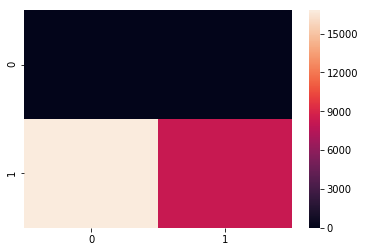

Learning Rate:[0.009779754323328192]
batch
batch
epoch3
train loss: 3.176677637384273e-05
Learning Rate:[0.009140576474687266]
batch
batch
epoch4
train loss: 3.159922925988212e-05
valid loss: 3.1517778552370146e-05
accuracy: 32.815998792648315 %


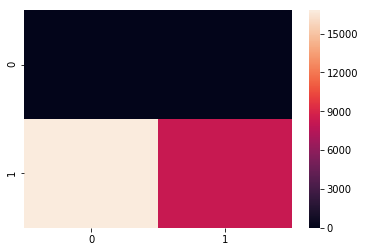

Learning Rate:[0.008145033635316129]
batch
batch
epoch5
train loss: 3.146130984532647e-05
Learning Rate:[0.006890576474687264]
batch
batch
epoch6
train loss: 3.135355655103922e-05
valid loss: 3.1304600270232186e-05
accuracy: 32.815998792648315 %


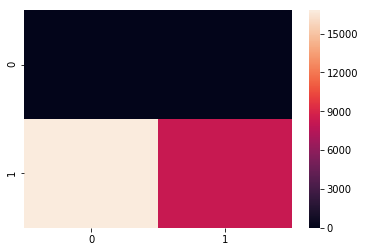

Learning Rate:[0.0055000000000000005]
batch
batch
epoch7
train loss: 3.127397576463409e-05
Learning Rate:[0.004109423525312737]
batch
batch
epoch8
train loss: 3.121874760836363e-05
valid loss: 3.119552638963796e-05
accuracy: 32.815998792648315 %


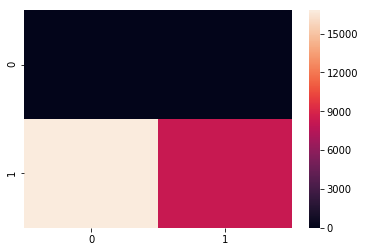

Learning Rate:[0.0028549663646838717]
batch
batch
epoch9
train loss: 3.1182738894131035e-05
Learning Rate:[0.0018594235253127371]
batch
batch
epoch10
train loss: 3.116000152658671e-05
valid loss: 3.115068830084056e-05
accuracy: 67.18400120735168 %
saved


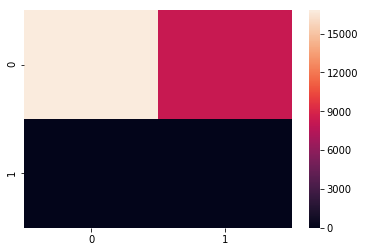

Learning Rate:[0.001220245676671809]
batch
batch
epoch11
train loss: 3.1144209060585126e-05
Learning Rate:[0.001]
batch
batch
epoch12
train loss: 3.112903505098075e-05
valid loss: 3.1120129278860986e-05
accuracy: 67.18400120735168 %


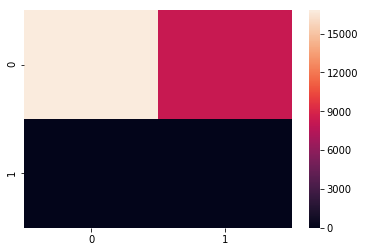

Learning Rate:[0.0012202456766718082]
batch
batch
epoch13
train loss: 3.110861507593654e-05
Learning Rate:[0.001859423525312736]
batch
batch
epoch14
train loss: 3.107799784629606e-05
valid loss: 3.105795258306898e-05
accuracy: 67.18400120735168 %


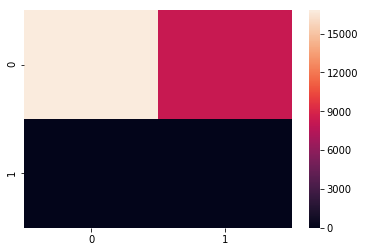

Learning Rate:[0.0028549663646838704]
batch
batch
epoch15
train loss: 3.103361450484954e-05
Learning Rate:[0.004109423525312737]
batch
batch
epoch16
train loss: 3.097366789006628e-05
valid loss: 3.093676423304714e-05
accuracy: 67.18400120735168 %


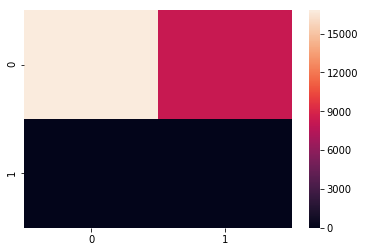

Learning Rate:[0.0055]
batch
batch
epoch17
train loss: 3.089838719461113e-05
Learning Rate:[0.006890576474687263]
batch
batch
epoch18
train loss: 3.0810006137471646e-05
valid loss: 3.075869972235523e-05
accuracy: 67.18400120735168 %


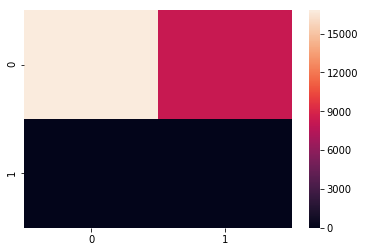

Learning Rate:[0.008145033635316129]
batch
batch
epoch19
train loss: 3.071250830544159e-05
Learning Rate:[0.009140576474687266]
batch
batch
epoch20
train loss: 3.061101961066015e-05
valid loss: 3.0554525437764823e-05
accuracy: 67.18400120735168 %


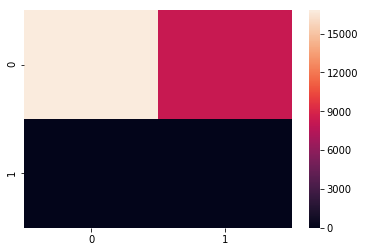

Learning Rate:[0.009779754323328192]
batch
batch
epoch21
train loss: 3.0511004297295585e-05
Learning Rate:[0.010000000000000002]
batch
batch
epoch22
train loss: 3.0417346351896413e-05
valid loss: 3.0366265491466038e-05
accuracy: 67.18400120735168 %


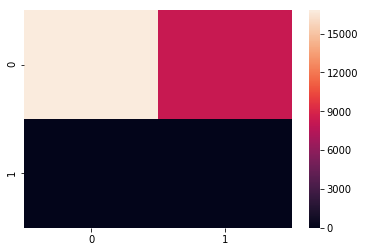

Learning Rate:[0.009779754323328192]
batch
batch
epoch23
train loss: 3.0333545510075055e-05
Learning Rate:[0.009140576474687266]
batch
batch
epoch24
train loss: 3.0261398933362216e-05
valid loss: 3.0221908673411235e-05
accuracy: 67.18400120735168 %


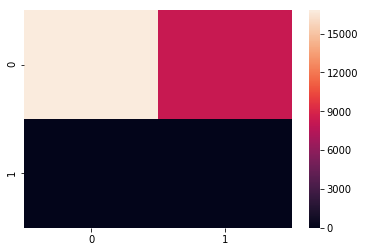

Learning Rate:[0.00814503363531613]
batch
batch
epoch25
train loss: 3.0201261324691586e-05
Learning Rate:[0.006890576474687265]
batch
batch
epoch26
train loss: 3.0152650651871227e-05
valid loss: 3.012617162312381e-05
accuracy: 67.18400120735168 %


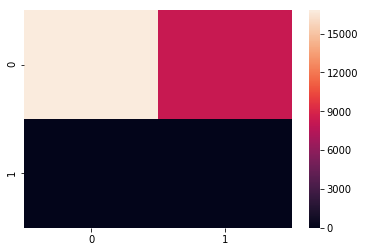

Learning Rate:[0.005500000000000001]
batch
batch
epoch27
train loss: 3.011480475834105e-05
Learning Rate:[0.004109423525312739]
batch
batch
epoch28
train loss: 3.008681596838869e-05
valid loss: 3.007254963449668e-05
accuracy: 67.18400120735168 %


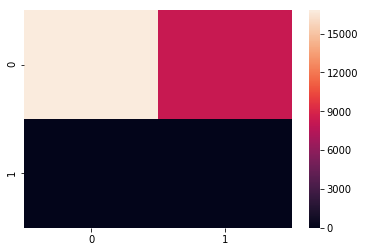

Learning Rate:[0.002854966364683872]
batch
batch
epoch29
train loss: 3.0067394618527032e-05
Learning Rate:[0.0018594235253127376]
batch
batch
epoch30
train loss: 3.0054541639401577e-05
valid loss: 3.0048266125959344e-05
accuracy: 67.18400120735168 %


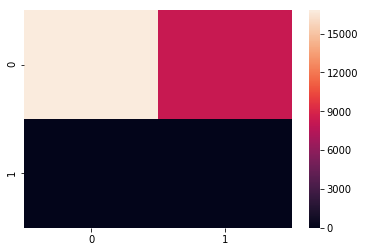

Learning Rate:[0.0012202456766718097]
batch
batch
epoch31
train loss: 3.0045464882277884e-05
Learning Rate:[0.001]
batch
batch
epoch32
train loss: 3.003682468261104e-05
valid loss: 3.003038546012249e-05
accuracy: 67.18400120735168 %


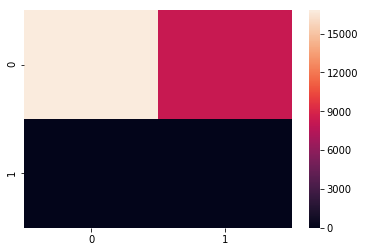

Learning Rate:[0.0012202456766718087]
batch
batch
epoch33
train loss: 3.002497942361515e-05
Learning Rate:[0.0018594235253127356]
batch
batch
epoch34
train loss: 3.0005990993231535e-05
valid loss: 2.998933086928446e-05
accuracy: 67.18400120735168 %


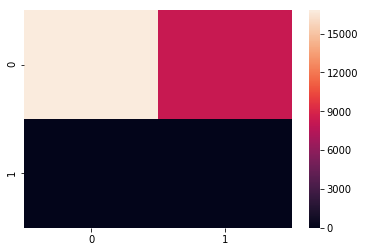

Learning Rate:[0.0028549663646838695]
batch
batch
epoch35
train loss: 2.99750390695408e-05
Learning Rate:[0.004109423525312735]
batch
batch
epoch36
train loss: 2.9925276976427995e-05
valid loss: 2.9882887247367762e-05
accuracy: 67.18400120735168 %


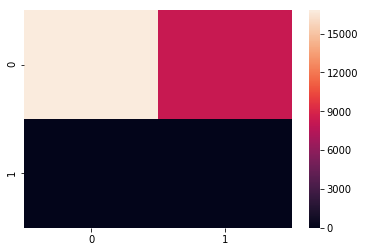

Learning Rate:[0.005499999999999999]
batch
batch
epoch37
train loss: 2.9845834433217533e-05
Learning Rate:[0.006890576474687262]
batch
batch
epoch38
train loss: 2.971912908833474e-05
valid loss: 2.961485370178707e-05
accuracy: 67.18400120735168 %


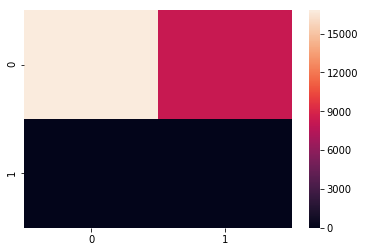

Learning Rate:[0.008145033635316129]
batch
batch
epoch39
train loss: 2.9518199880840257e-05
Learning Rate:[0.009140576474687263]
batch
batch
epoch40
train loss: 2.920688348240219e-05
valid loss: 2.896853766287677e-05
accuracy: 67.18400120735168 %


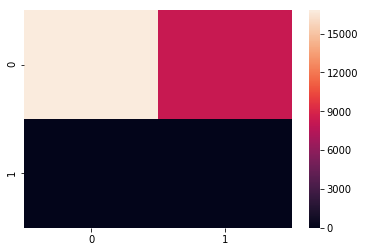

Learning Rate:[0.009779754323328192]
batch
batch
epoch41
train loss: 2.8747939722961746e-05
Learning Rate:[0.010000000000000002]
batch
batch
epoch42
train loss: 2.8122212825110182e-05
valid loss: 2.7702430088538677e-05
accuracy: 67.18400120735168 %


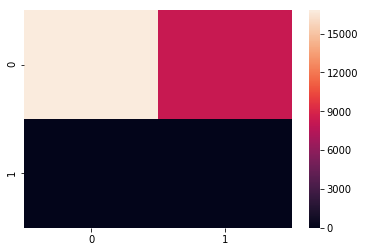

Learning Rate:[0.009779754323328196]
batch
batch
epoch43
train loss: 2.7347785362508148e-05
Learning Rate:[0.009140576474687266]
batch
batch
epoch44
train loss: 2.6479445295990445e-05
valid loss: 2.59686894423794e-05
accuracy: 67.18400120735168 %


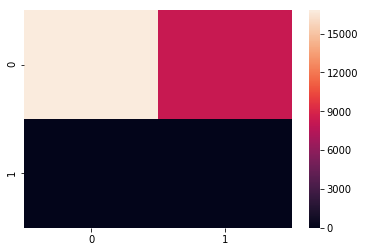

Learning Rate:[0.008145033635316132]
batch
batch
epoch45
train loss: 2.5587405616533943e-05
Learning Rate:[0.0068905764746872745]
batch
batch
epoch46
train loss: 2.4752207536948845e-05
valid loss: 2.431836401228793e-05
accuracy: 90.39199948310852 %
saved


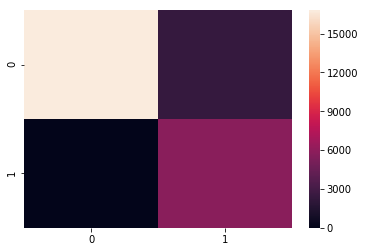

Learning Rate:[0.005500000000000002]
batch
batch
epoch47
train loss: 2.404293991276063e-05
Learning Rate:[0.0041094235253127396]
batch
batch
epoch48
train loss: 2.3495504137827083e-05
valid loss: 2.325973218830768e-05
accuracy: 91.95599555969238 %
saved


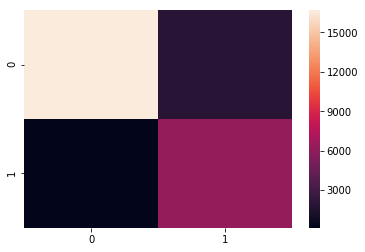

Learning Rate:[0.002854966364683867]
batch
batch
epoch49
train loss: 2.314031371497549e-05
Learning Rate:[0.001859423525312738]
batch
batch
epoch50
train loss: 2.2916363377589732e-05
valid loss: 2.2817464923718944e-05
accuracy: 92.37599968910217 %
saved


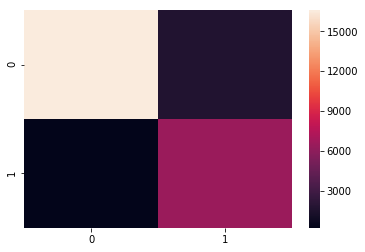

Learning Rate:[0.0012202456766718121]
batch
batch
epoch51
train loss: 2.27495220315177e-05
Learning Rate:[0.001]
batch
batch
epoch52
train loss: 2.2575708499061875e-05
valid loss: 2.2467735107056797e-05
accuracy: 92.4239993095398 %
saved


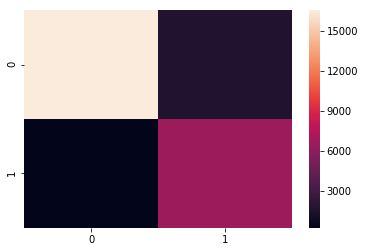

Learning Rate:[0.0012202456766718056]
batch
batch
epoch53
train loss: 2.2331576474243775e-05
Learning Rate:[0.001859423525312735]
batch
batch
epoch54
train loss: 2.1969579393044114e-05
valid loss: 2.1737210772698745e-05
accuracy: 92.39199757575989 %


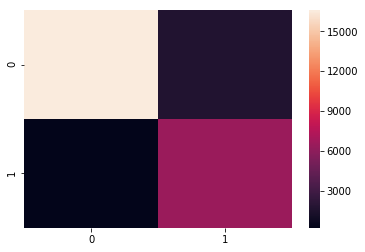

Learning Rate:[0.002854966364683875]
batch
batch
epoch55
train loss: 2.146672886738088e-05
Learning Rate:[0.0041094235253127335]
batch
batch
epoch56
train loss: 2.0799281628569588e-05
valid loss: 2.03848430828657e-05
accuracy: 92.603999376297 %
saved


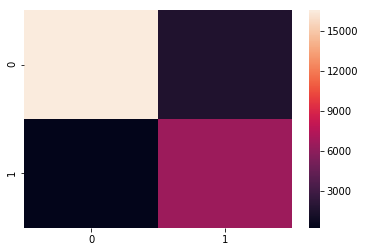

Learning Rate:[0.005500000000000006]
batch
batch
epoch57
train loss: 1.998141669901088e-05
Learning Rate:[0.0068905764746872615]
batch
batch
epoch58
train loss: 1.913833875732962e-05
valid loss: 1.8603281205287203e-05
accuracy: 92.61999726295471 %
saved


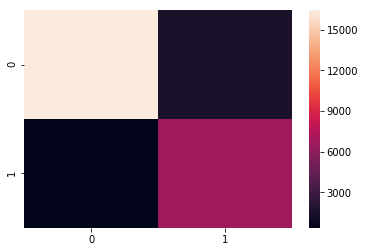

Learning Rate:[0.008145033635316122]
batch
batch
epoch59
train loss: 1.8180146071244963e-05
Learning Rate:[0.009140576474687263]
batch
batch
epoch60
train loss: 1.7337200915790163e-05
valid loss: 1.6869720639078878e-05
accuracy: 92.58399605751038 %


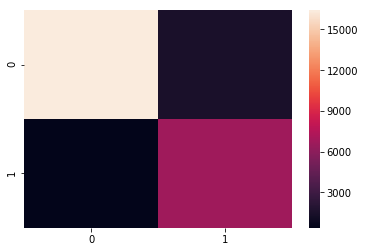

Learning Rate:[0.009779754323328189]
batch
batch
epoch61
train loss: 1.6647998563712463e-05
Learning Rate:[0.010000000000000002]
batch
batch
epoch62
train loss: 1.5933490431052633e-05
valid loss: 1.5535966667812318e-05
accuracy: 92.69599914550781 %
saved


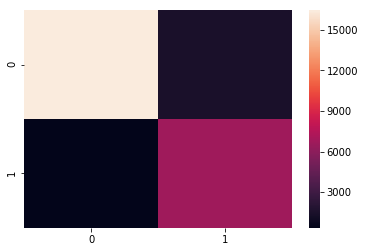

Learning Rate:[0.009779754323328189]
batch
batch
epoch63
train loss: 1.5395766240544617e-05
Learning Rate:[0.009140576474687266]
batch
batch
epoch64
train loss: 1.4847465536149684e-05
valid loss: 1.4631914382334799e-05
accuracy: 92.64000058174133 %


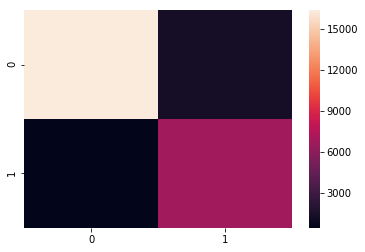

Learning Rate:[0.008145033635316127]
batch
batch
epoch65
train loss: 1.4718340025865473e-05
Learning Rate:[0.006890576474687268]
batch
batch
epoch66
train loss: 1.428571340511553e-05
valid loss: 1.4169913811201695e-05
accuracy: 92.58399605751038 %


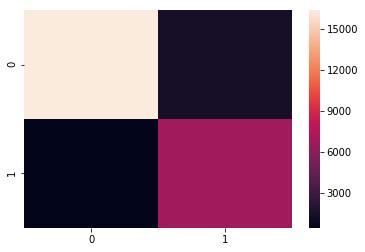

Learning Rate:[0.005500000000000013]
batch
batch
epoch67
train loss: 1.4111862583376933e-05
Learning Rate:[0.00410942352531274]
batch
batch
epoch68
train loss: 1.3989380022394471e-05
valid loss: 1.3934764865553007e-05
accuracy: 92.29999780654907 %


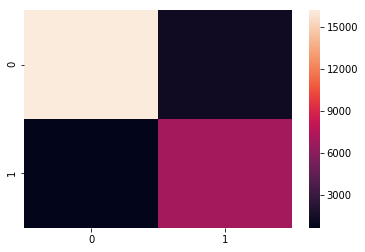

Learning Rate:[0.0028549663646838808]
batch
batch
epoch69
train loss: 1.3936934919911437e-05
Learning Rate:[0.001859423525312739]
batch
batch
epoch70
train loss: 1.3878752724849619e-05
valid loss: 1.3840498468198348e-05
accuracy: 92.31999516487122 %


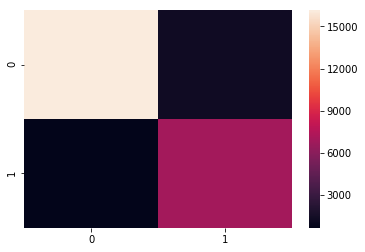

Learning Rate:[0.0012202456766718076]
batch
batch
epoch71
train loss: 1.382603841193486e-05
Learning Rate:[0.001]
batch
batch
epoch72
train loss: 1.3785120245302096e-05
valid loss: 1.3761386981059331e-05
accuracy: 92.41199493408203 %


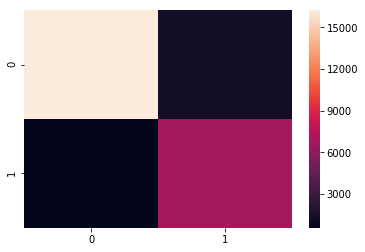

Learning Rate:[0.0012202456766718102]
batch
batch
epoch73
train loss: 1.3744465832132846e-05
Learning Rate:[0.0018594235253127345]
batch
batch
epoch74
train loss: 1.3690494597540237e-05
valid loss: 1.3640364159073215e-05
accuracy: 92.36399531364441 %


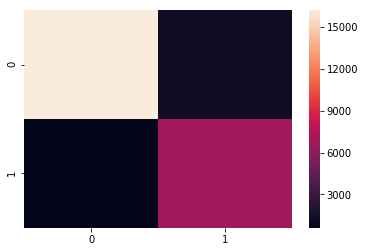

Learning Rate:[0.0028549663646838617]
batch
batch
epoch75
train loss: 1.3631812180392444e-05
Learning Rate:[0.0041094235253127335]
batch
batch
epoch76
train loss: 1.350217735307524e-05
valid loss: 1.3405436220637057e-05
accuracy: 92.49999523162842 %


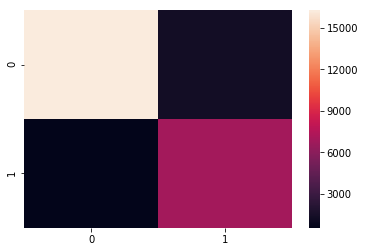

Learning Rate:[0.005499999999999988]
batch
batch
epoch77
train loss: 1.3365915947360918e-05
Learning Rate:[0.006890576474687261]
batch
batch
epoch78
train loss: 1.326073834206909e-05
valid loss: 1.3101089280098677e-05
accuracy: 92.46799945831299 %


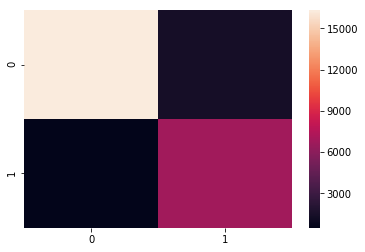

Learning Rate:[0.008145033635316132]
batch
batch
epoch79
train loss: 1.3180422683944926e-05
Learning Rate:[0.009140576474687263]
batch
batch
epoch80
train loss: 1.3142000170773827e-05
valid loss: 1.2877554581791628e-05
accuracy: 92.30799674987793 %


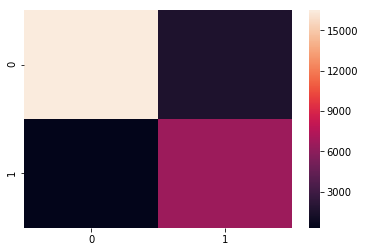

Learning Rate:[0.009779754323328192]
batch
batch
epoch81
train loss: 1.3036606105742976e-05
Learning Rate:[0.010000000000000002]
batch
batch
epoch82
train loss: 1.2800202966900542e-05
valid loss: 1.255072402273072e-05
accuracy: 92.50399470329285 %


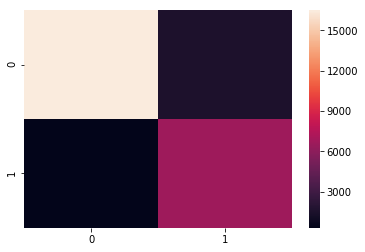

Learning Rate:[0.009779754323328196]
batch
batch
epoch83
train loss: 1.2533080735011026e-05
Learning Rate:[0.009140576474687277]
batch
batch
epoch84
train loss: 1.242536018253304e-05
valid loss: 1.231105579790892e-05
accuracy: 92.16799736022949 %


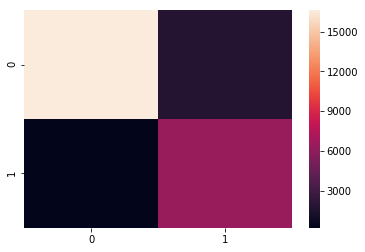

Learning Rate:[0.008145033635316127]
batch
batch
epoch85
train loss: 1.2414324373821728e-05
Learning Rate:[0.0068905764746872685]
batch
batch
epoch86
train loss: 1.208415505971061e-05
valid loss: 1.1941899174416903e-05
accuracy: 92.36399531364441 %


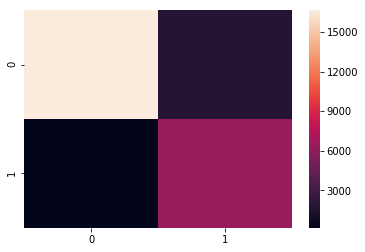

Learning Rate:[0.005499999999999997]
batch
batch
epoch87
train loss: 1.1882302715093829e-05
Learning Rate:[0.004109423525312742]
batch
batch
epoch88
train loss: 1.1751438250939827e-05
valid loss: 1.1690150131471455e-05
accuracy: 92.80799627304077 %
saved


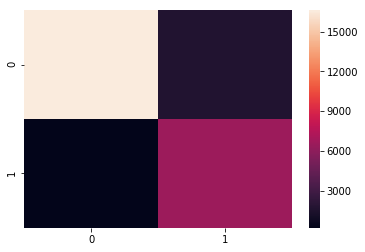

Learning Rate:[0.0028549663646838816]
batch
batch
epoch89
train loss: 1.1679347153403796e-05
Learning Rate:[0.001859423525312749]
batch
batch
epoch90
train loss: 1.1617550626397133e-05
valid loss: 1.15839839054388e-05
accuracy: 92.81999468803406 %
saved


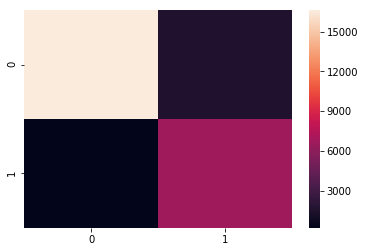

Learning Rate:[0.0012202456766718082]
batch
batch
epoch91
train loss: 1.157112910732394e-05
Learning Rate:[0.001]
batch
batch
epoch92
train loss: 1.1536923921084963e-05
valid loss: 1.1515014193719253e-05
accuracy: 92.75999665260315 %


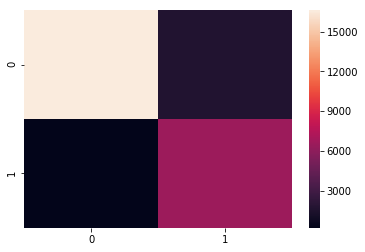

Learning Rate:[0.0012202456766718052]
batch
batch
epoch93
train loss: 1.1502312190714292e-05
Learning Rate:[0.0018594235253127337]
batch
batch
epoch94
train loss: 1.146048725786386e-05
valid loss: 1.1416714187362231e-05
accuracy: 92.74799823760986 %


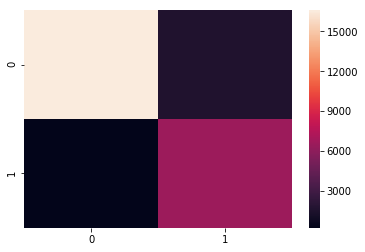

Learning Rate:[0.002854966364683861]
batch
batch
epoch95
train loss: 1.1418153917475138e-05
Learning Rate:[0.004109423525312747]
batch
batch
epoch96
train loss: 1.133140358433593e-05
valid loss: 1.1251471732975915e-05
accuracy: 92.65199899673462 %


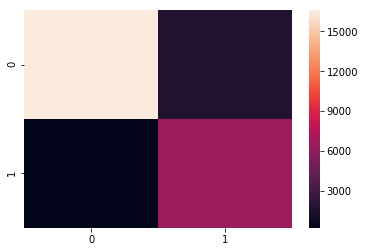

Learning Rate:[0.005500000000000003]
batch
batch
epoch97
train loss: 1.1247372640355024e-05
Learning Rate:[0.006890576474687259]
batch
batch
epoch98
train loss: 1.119741500588134e-05
valid loss: 1.1016378266504034e-05
accuracy: 92.65599846839905 %


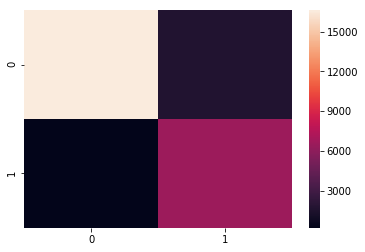

Learning Rate:[0.008145033635316119]
batch
batch
epoch99
train loss: 1.0972389645758085e-05
Learning Rate:[0.009140576474687252]
batch
batch
epoch100
train loss: 1.0938585546682589e-05
valid loss: 1.0762096280814148e-05
accuracy: 92.631995677948 %


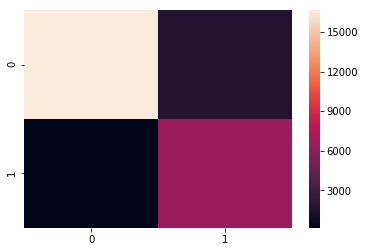

Learning Rate:[0.009779754323328192]
batch
batch
epoch101
train loss: 1.0574452062428463e-05
Learning Rate:[0.010000000000000002]
batch
batch
epoch102
train loss: 1.0588564691715874e-05
valid loss: 1.068289657268906e-05
accuracy: 92.69199967384338 %


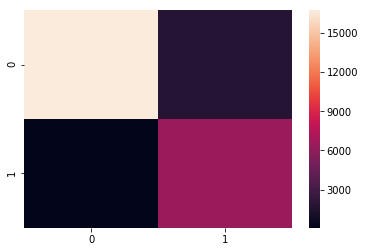

Learning Rate:[0.009779754323328192]
batch
batch
epoch103
train loss: 1.0535723959037568e-05
Learning Rate:[0.009140576474687277]
batch
batch
epoch104
train loss: 1.1053048183384817e-05
valid loss: 1.0382600521552376e-05
accuracy: 92.83199906349182 %
saved


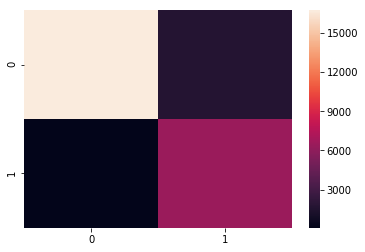

Learning Rate:[0.008145033635316141]
batch
batch
epoch105
train loss: 1.0783897778310347e-05
Learning Rate:[0.006890576474687269]
batch
batch
epoch106
train loss: 1.0117733836523257e-05
valid loss: 1.0440138794365339e-05
accuracy: 93.6519980430603 %
saved


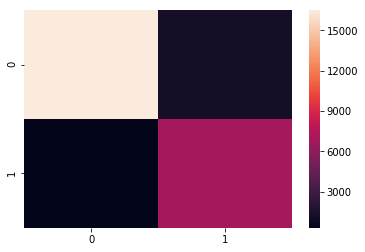

Learning Rate:[0.005499999999999999]
batch
batch
epoch107
train loss: 1.0901752830250189e-05
Learning Rate:[0.004109423525312727]
batch
batch
epoch108
train loss: 9.983860763895791e-06
valid loss: 1.0101326552103274e-05
accuracy: 92.96000003814697 %


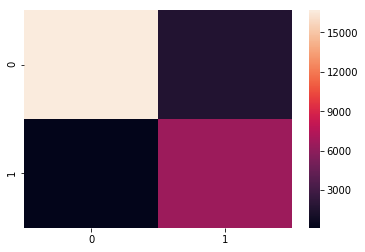

Learning Rate:[0.0028549663646838825]
batch
batch
epoch109
train loss: 1.014134795696009e-05
Learning Rate:[0.0018594235253127402]
batch
batch
epoch110
train loss: 1.0072234545077663e-05
valid loss: 9.998007044487167e-06
accuracy: 93.04800033569336 %


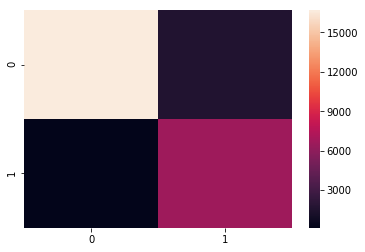

Learning Rate:[0.0012202456766718182]
batch
batch
epoch111
train loss: 9.973065061785746e-06
Learning Rate:[0.001]
batch
batch
epoch112
train loss: 1.0022168680734467e-05
valid loss: 1.0078940249513835e-05
accuracy: 93.2479977607727 %


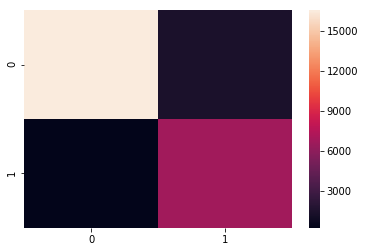

Learning Rate:[0.0012202456766718048]
batch
batch
epoch113
train loss: 1.0201606528426055e-05
Learning Rate:[0.0018594235253127332]
batch
batch
epoch114
train loss: 1.0055907296191435e-05
valid loss: 9.938212315319106e-06
accuracy: 93.01599860191345 %


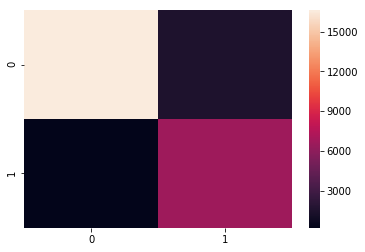

Learning Rate:[0.0028549663646838725]
batch
batch
epoch115
train loss: 9.953759217751212e-06
Learning Rate:[0.004109423525312716]
batch
batch
epoch116
train loss: 9.946820682671387e-06
valid loss: 9.901573321258184e-06
accuracy: 93.04800033569336 %


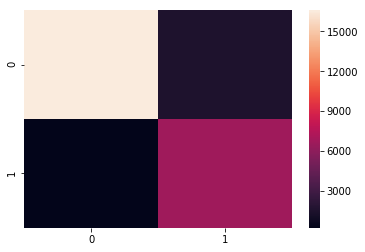

Learning Rate:[0.005500000000000019]
batch
batch
epoch117
train loss: 1.0240567462460604e-05
Learning Rate:[0.006890576474687258]
batch
batch
epoch118
train loss: 9.81544053502148e-06
valid loss: 9.83886366157094e-06
accuracy: 92.96000003814697 %


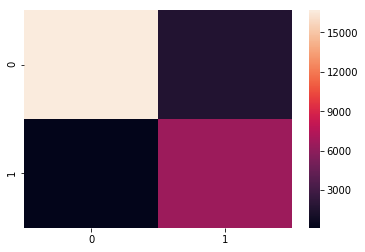

Learning Rate:[0.00814503363531613]
batch
batch
epoch119
train loss: 9.782637789612636e-06
Learning Rate:[0.009140576474687249]
batch
batch
epoch120
train loss: 9.90080206975108e-06
valid loss: 9.664166100264993e-06
accuracy: 93.07599663734436 %


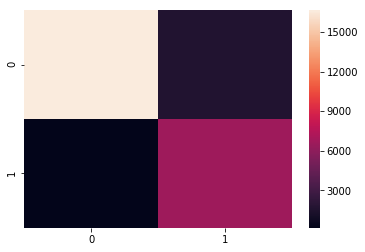

Learning Rate:[0.009779754323328189]
batch
batch
epoch121
train loss: 9.674659850134049e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch122
train loss: 9.933760338753927e-06
valid loss: 9.49720197240822e-06
accuracy: 93.24399828910828 %


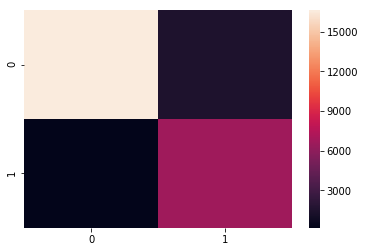

Learning Rate:[0.009779754323328192]
batch
batch
epoch123
train loss: 9.564185347699095e-06
Learning Rate:[0.00914057647468726]
batch
batch
epoch124
train loss: 9.640339158067945e-06
valid loss: 9.462758498557378e-06
accuracy: 93.52799654006958 %


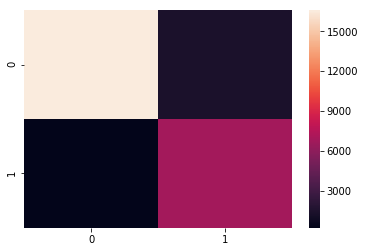

Learning Rate:[0.008145033635316143]
batch
batch
epoch125
train loss: 9.448130185774062e-06
Learning Rate:[0.00689057647468727]
batch
batch
epoch126
train loss: 9.418172339792363e-06
valid loss: 9.391917046741582e-06
accuracy: 93.34399700164795 %


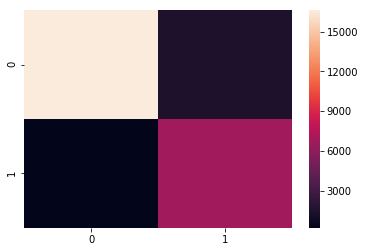

Learning Rate:[0.005500000000000032]
batch
batch
epoch127
train loss: 9.471981684328057e-06
Learning Rate:[0.004109423525312728]
batch
batch
epoch128
train loss: 9.428546945855487e-06
valid loss: 9.372070962854195e-06
accuracy: 93.38399767875671 %


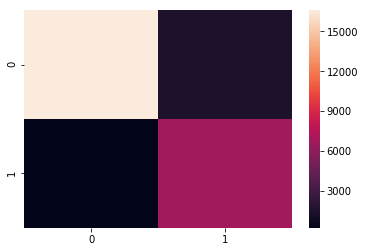

Learning Rate:[0.0028549663646838834]
batch
batch
epoch129
train loss: 9.369327926833648e-06
Learning Rate:[0.001859423525312741]
batch
batch
epoch130
train loss: 9.358460374642164e-06
valid loss: 9.351603694085497e-06
accuracy: 93.35599541664124 %


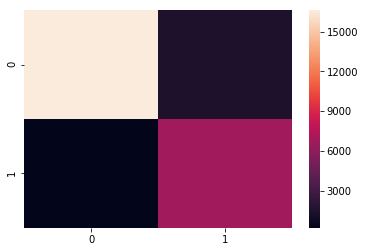

Learning Rate:[0.0012202456766718087]
batch
batch
epoch131
train loss: 9.35789921641117e-06
Learning Rate:[0.001]
batch
batch
epoch132
train loss: 9.368991413793992e-06
valid loss: 9.362600394524634e-06
accuracy: 93.46799850463867 %


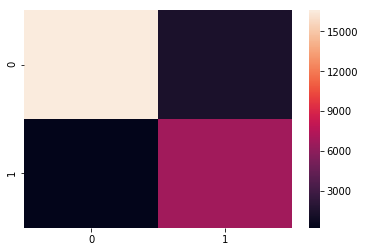

Learning Rate:[0.001220245676671814]
batch
batch
epoch133
train loss: 9.384465556649957e-06
Learning Rate:[0.0018594235253127326]
batch
batch
epoch134
train loss: 9.358785064250696e-06
valid loss: 9.316770047007594e-06
accuracy: 93.41599941253662 %


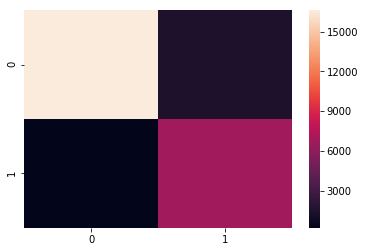

Learning Rate:[0.0028549663646838717]
batch
batch
epoch135
train loss: 9.316247087554075e-06
Learning Rate:[0.004109423525312714]
batch
batch
epoch136
train loss: 9.318306183558889e-06
valid loss: 9.267935638490599e-06
accuracy: 93.49599480628967 %


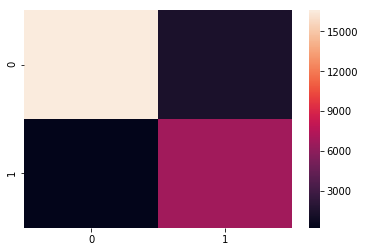

Learning Rate:[0.005499999999999985]
batch
batch
epoch137
train loss: 9.323690392193384e-06
Learning Rate:[0.006890576474687257]
batch
batch
epoch138
train loss: 9.230479008692782e-06
valid loss: 9.182916983263567e-06
accuracy: 93.55199933052063 %


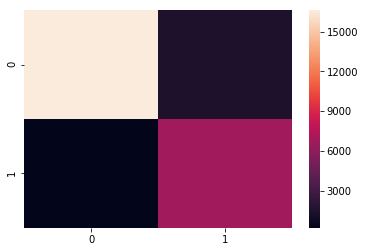

Learning Rate:[0.00814503363531613]
batch
batch
epoch139
train loss: 9.301057616539765e-06
Learning Rate:[0.00914057647468727]
batch
batch
epoch140
train loss: 9.14864540391136e-06
valid loss: 9.099114322452806e-06
accuracy: 93.66799592971802 %
saved


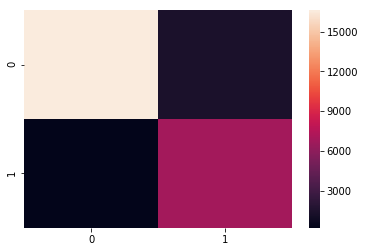

Learning Rate:[0.009779754323328189]
batch
batch
epoch141
train loss: 9.310822861152701e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch142
train loss: 9.11279312276747e-06
valid loss: 9.152774509857409e-06
accuracy: 93.85199546813965 %
saved


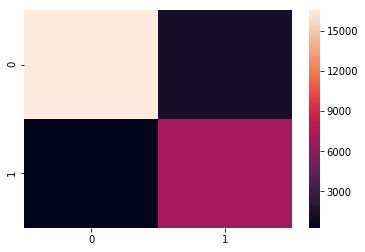

Learning Rate:[0.009779754323328203]
batch
batch
epoch143
train loss: 9.517987564322539e-06
Learning Rate:[0.00914057647468726]
batch
batch
epoch144
train loss: 9.547431545797735e-06
valid loss: 8.983884072222281e-06
accuracy: 93.80799531936646 %


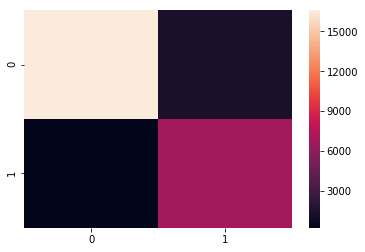

Learning Rate:[0.008145033635316143]
batch
batch
epoch145
train loss: 1.0086706424772274e-05
Learning Rate:[0.006890576474687272]
batch
batch
epoch146
train loss: 9.341503755422309e-06
valid loss: 9.332765330327675e-06
accuracy: 93.20799708366394 %


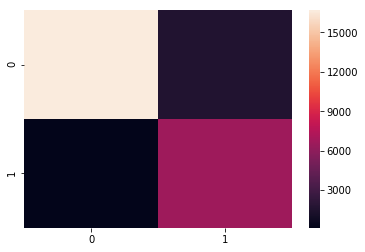

Learning Rate:[0.0055000000000000005]
batch
batch
epoch147
train loss: 9.055627742782235e-06
Learning Rate:[0.0041094235253127595]
batch
batch
epoch148
train loss: 9.410182428837288e-06
valid loss: 9.205728019878734e-06
accuracy: 93.93999576568604 %
saved


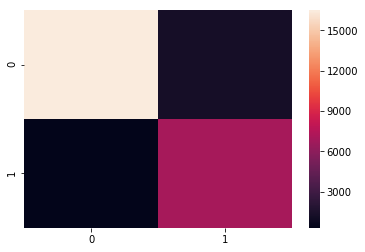

Learning Rate:[0.002854966364683858]
batch
batch
epoch149
train loss: 9.087972102861386e-06
Learning Rate:[0.0018594235253127415]
batch
batch
epoch150
train loss: 8.980628081189934e-06
valid loss: 9.00881514098728e-06
accuracy: 93.57999563217163 %


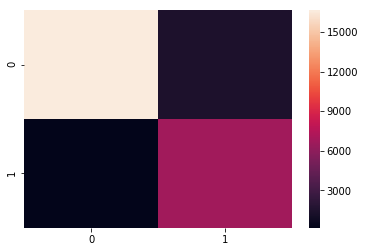

Learning Rate:[0.001220245676671809]
batch
batch
epoch151
train loss: 9.018685886985622e-06
Learning Rate:[0.001]
batch
batch
epoch152
train loss: 9.00504983292194e-06
valid loss: 8.988625268102624e-06
accuracy: 93.68799924850464 %


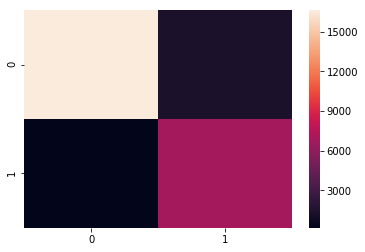

Learning Rate:[0.001220245676671804]
batch
batch
epoch153
train loss: 9.03832733456511e-06
Learning Rate:[0.0018594235253127315]
batch
batch
epoch154
train loss: 9.212160875904374e-06
valid loss: 9.0830544650089e-06
accuracy: 93.74399781227112 %


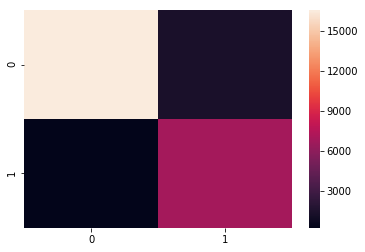

Learning Rate:[0.0028549663646838704]
batch
batch
epoch155
train loss: 9.024970495374873e-06
Learning Rate:[0.004109423525312744]
batch
batch
epoch156
train loss: 9.030656656250358e-06
valid loss: 8.997316399472766e-06
accuracy: 93.63600015640259 %


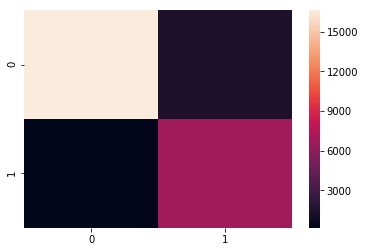

Learning Rate:[0.005499999999999984]
batch
batch
epoch157
train loss: 9.270695045415778e-06
Learning Rate:[0.006890576474687256]
batch
batch
epoch158
train loss: 8.948364666139241e-06
valid loss: 8.93701144377701e-06
accuracy: 93.61199736595154 %


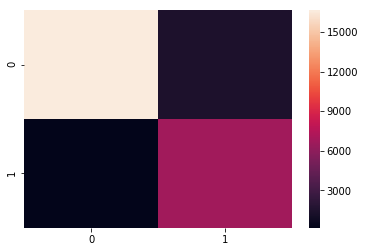

Learning Rate:[0.008145033635316103]
batch
batch
epoch159
train loss: 9.009125278680585e-06
Learning Rate:[0.00914057647468727]
batch
batch
epoch160
train loss: 8.868991244526114e-06
valid loss: 8.834195796225686e-06
accuracy: 93.7999963760376 %


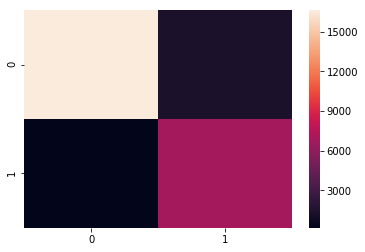

Learning Rate:[0.009779754323328185]
batch
batch
epoch161
train loss: 8.87240003066836e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch162
train loss: 8.8714459707262e-06
valid loss: 8.815175533527508e-06
accuracy: 93.7720000743866 %


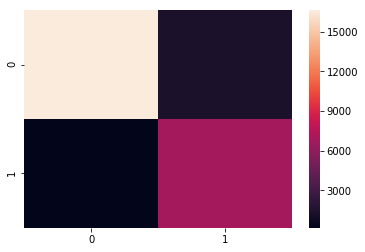

Learning Rate:[0.009779754323328192]
batch
batch
epoch163
train loss: 8.855707164912019e-06
Learning Rate:[0.00914057647468728]
batch
batch
epoch164
train loss: 8.899191016098484e-06
valid loss: 8.794741916062776e-06
accuracy: 93.76399517059326 %


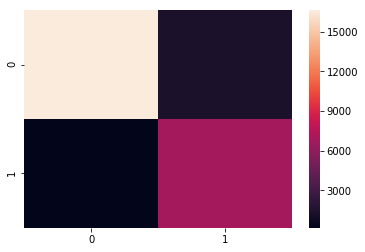

Learning Rate:[0.008145033635316143]
batch
batch
epoch165
train loss: 8.798128874332178e-06
Learning Rate:[0.006890576474687303]
batch
batch
epoch166
train loss: 8.867627911968157e-06
valid loss: 8.746452294872142e-06
accuracy: 93.78399848937988 %


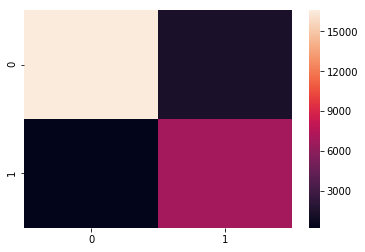

Learning Rate:[0.0055000000000000335]
batch
batch
epoch167
train loss: 8.751257155381609e-06
Learning Rate:[0.00410942352531273]
batch
batch
epoch168
train loss: 8.752316716709174e-06
valid loss: 8.742538739170413e-06
accuracy: 93.83599758148193 %


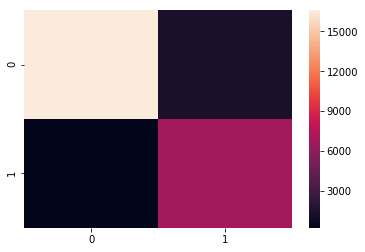

Learning Rate:[0.002854966364683859]
batch
batch
epoch169
train loss: 8.770501153776422e-06
Learning Rate:[0.0018594235253127421]
batch
batch
epoch170
train loss: 8.758834155742079e-06
valid loss: 8.741927558730822e-06
accuracy: 93.82799863815308 %


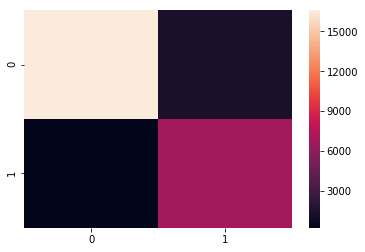

Learning Rate:[0.001220245676671809]
batch
batch
epoch171
train loss: 8.74452234711498e-06
Learning Rate:[0.001]
batch
batch
epoch172
train loss: 8.741181773075368e-06
valid loss: 8.734553375688847e-06
accuracy: 93.78399848937988 %


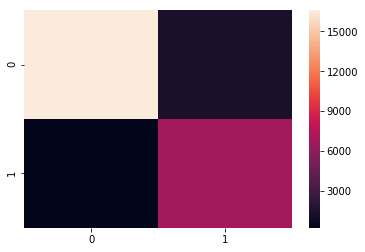

Learning Rate:[0.0012202456766718037]
batch
batch
epoch173
train loss: 8.749963853915688e-06
Learning Rate:[0.001859423525312731]
batch
batch
epoch174
train loss: 8.776036338531412e-06
valid loss: 8.744846127228811e-06
accuracy: 93.81199479103088 %


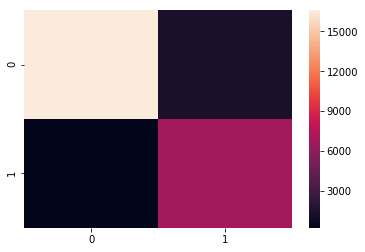

Learning Rate:[0.0028549663646838443]
batch
batch
epoch175
train loss: 8.779663403402083e-06
Learning Rate:[0.004109423525312713]
batch
batch
epoch176
train loss: 8.767849067226052e-06
valid loss: 8.723251085029915e-06
accuracy: 93.76399517059326 %


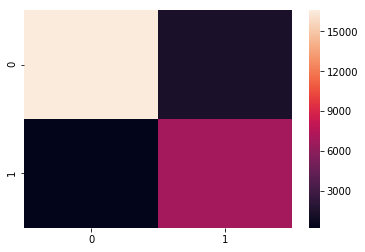

Learning Rate:[0.005499999999999983]
batch
batch
epoch177
train loss: 8.812812666292302e-06
Learning Rate:[0.006890576474687224]
batch
batch
epoch178
train loss: 8.735783012525644e-06
valid loss: 8.672013791510835e-06
accuracy: 93.75999569892883 %


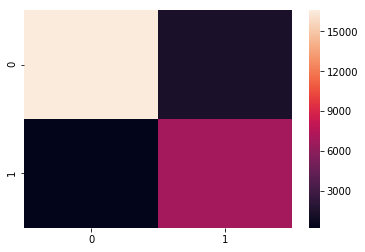

Learning Rate:[0.008145033635316129]
batch
batch
epoch179
train loss: 8.789184903434943e-06
Learning Rate:[0.00914057647468727]
batch
batch
epoch180
train loss: 8.671946488902904e-06
valid loss: 8.621241249784362e-06
accuracy: 93.83999705314636 %


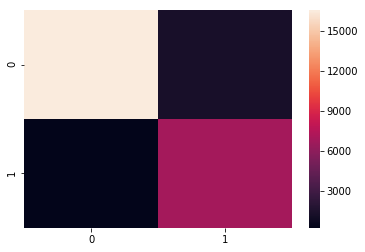

Learning Rate:[0.009779754323328196]
batch
batch
epoch181
train loss: 8.791476830083411e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch182
train loss: 8.671509021951351e-06
valid loss: 8.80956940818578e-06
accuracy: 94.1279947757721 %
saved


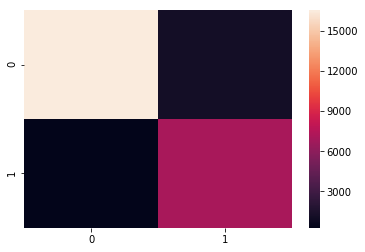

Learning Rate:[0.009779754323328192]
batch
batch
epoch183
train loss: 8.855924534145743e-06
Learning Rate:[0.00914057647468728]
batch
batch
epoch184
train loss: 8.842584065860137e-06
valid loss: 9.177186257147696e-06
accuracy: 94.27199959754944 %
saved


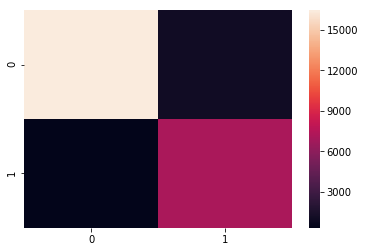

Learning Rate:[0.008145033635316145]
batch
batch
epoch185
train loss: 9.721590686240233e-06
Learning Rate:[0.0068905764746872745]
batch
batch
epoch186
train loss: 9.941973985405639e-06
valid loss: 9.314149792771786e-06
accuracy: 93.28399896621704 %


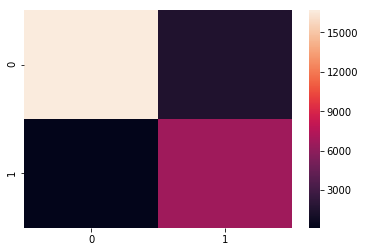

Learning Rate:[0.005500000000000034]
batch
batch
epoch187
train loss: 8.719043762539513e-06
Learning Rate:[0.004109423525312761]
batch
batch
epoch188
train loss: 9.971092367777601e-06
valid loss: 8.797060218057595e-06
accuracy: 94.08400058746338 %


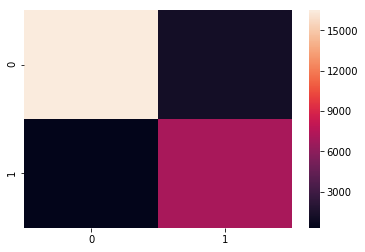

Learning Rate:[0.00285496636468386]
batch
batch
epoch189
train loss: 8.626978342363145e-06
Learning Rate:[0.0018594235253127241]
batch
batch
epoch190
train loss: 8.858890396368224e-06
valid loss: 8.893503036233597e-06
accuracy: 93.6519980430603 %


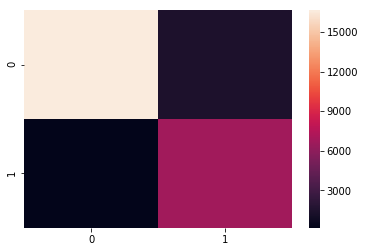

Learning Rate:[0.0012202456766718097]
batch
batch
epoch191
train loss: 8.844743206282146e-06
Learning Rate:[0.001]
batch
batch
epoch192
train loss: 8.678693120600656e-06
valid loss: 8.672122930875048e-06
accuracy: 93.84799599647522 %


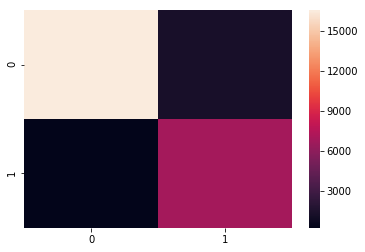

Learning Rate:[0.0012202456766718032]
batch
batch
epoch193
train loss: 8.928187526180409e-06
Learning Rate:[0.0018594235253127306]
batch
batch
epoch194
train loss: 9.126011718763039e-06
valid loss: 8.736727977520786e-06
accuracy: 93.82799863815308 %


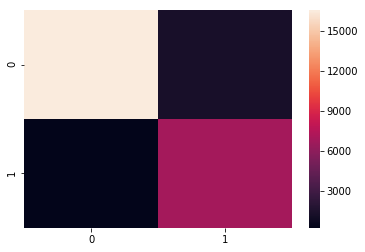

Learning Rate:[0.002854966364683869]
batch
batch
epoch195
train loss: 8.731527486816049e-06
Learning Rate:[0.004109423525312712]
batch
batch
epoch196
train loss: 8.815793989924714e-06
valid loss: 8.777800758252852e-06
accuracy: 93.65999698638916 %


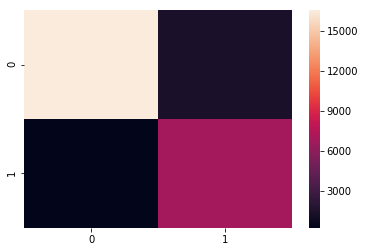

Learning Rate:[0.0054999999999999815]
batch
batch
epoch197
train loss: 9.747845979291014e-06
Learning Rate:[0.006890576474687223]
batch
batch
epoch198
train loss: 8.921804692363366e-06
valid loss: 8.813543900032528e-06
accuracy: 93.55199933052063 %


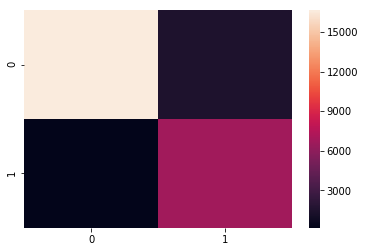

Learning Rate:[0.008145033635316101]
batch
batch
epoch199
train loss: 9.123638847086113e-06
Learning Rate:[0.009140576474687266]
batch
batch
epoch200
train loss: 8.601053195889108e-06
valid loss: 8.65461061039241e-06
accuracy: 93.65599751472473 %


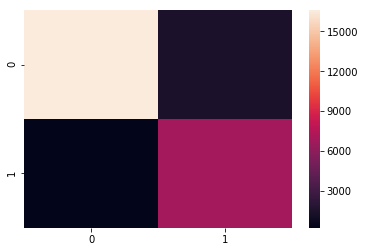

Learning Rate:[0.009779754323328196]
batch
batch
epoch201
train loss: 8.63345485413447e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch202
train loss: 8.727015483600553e-06
valid loss: 8.665718269185163e-06
accuracy: 93.60399842262268 %


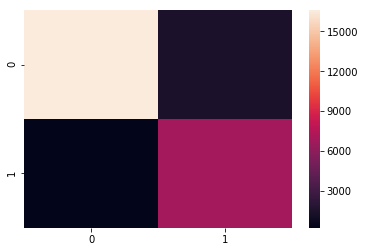

Learning Rate:[0.009779754323328192]
batch
batch
epoch203
train loss: 8.655901183374226e-06
Learning Rate:[0.009140576474687263]
batch
batch
epoch204
train loss: 9.08799484022893e-06
valid loss: 8.654906196170487e-06
accuracy: 93.59999895095825 %


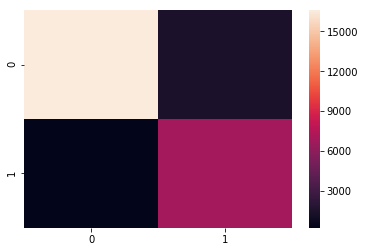

Learning Rate:[0.008145033635316145]
batch
batch
epoch205
train loss: 8.681384315423202e-06
Learning Rate:[0.006890576474687305]
batch
batch
epoch206
train loss: 8.779489689914044e-06
valid loss: 8.700789294380229e-06
accuracy: 93.86000037193298 %


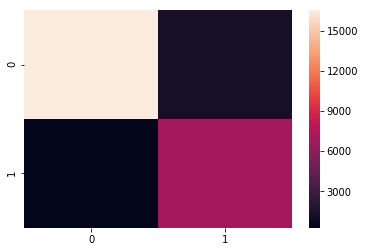

Learning Rate:[0.005500000000000035]
batch
batch
epoch207
train loss: 8.708923814992886e-06
Learning Rate:[0.004109423525312763]
batch
batch
epoch208
train loss: 8.587288903072476e-06
valid loss: 8.58603380038403e-06
accuracy: 93.62399578094482 %


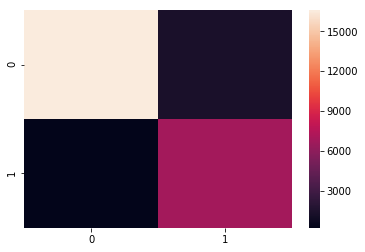

Learning Rate:[0.002854966364683887]
batch
batch
epoch209
train loss: 8.584845090808813e-06
Learning Rate:[0.0018594235253127436]
batch
batch
epoch210
train loss: 8.597538908361457e-06
valid loss: 8.601448826084379e-06
accuracy: 93.78799796104431 %


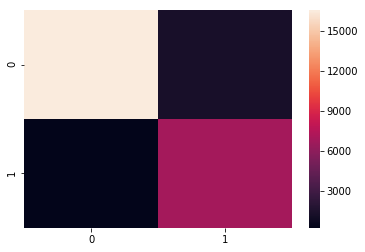

Learning Rate:[0.0012202456766718102]
batch
batch
epoch211
train loss: 8.625475857115816e-06
Learning Rate:[0.001]
batch
batch
epoch212
train loss: 8.629308467789087e-06
valid loss: 8.603359674452804e-06
accuracy: 93.79199743270874 %


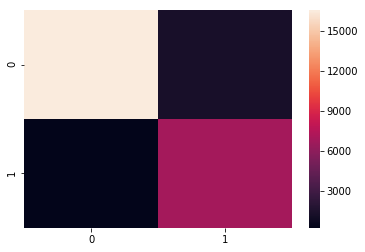

Learning Rate:[0.0012202456766718126]
batch
batch
epoch213
train loss: 8.599041393608786e-06
Learning Rate:[0.0018594235253127486]
batch
batch
epoch214
train loss: 8.581597285228781e-06
valid loss: 8.574128514737822e-06
accuracy: 93.63199472427368 %


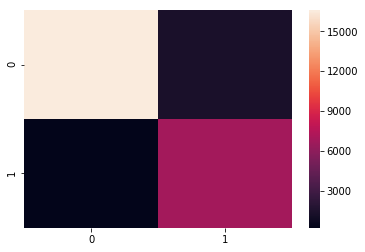

Learning Rate:[0.002854966364683842]
batch
batch
epoch215
train loss: 8.609578799223527e-06
Learning Rate:[0.004109423525312711]
batch
batch
epoch216
train loss: 8.692950359545648e-06
valid loss: 8.571963917347603e-06
accuracy: 93.66799592971802 %


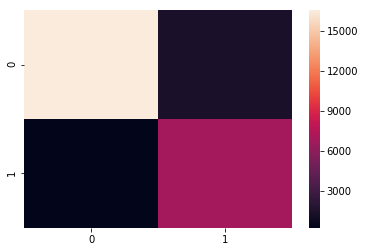

Learning Rate:[0.005499999999999981]
batch
batch
epoch217
train loss: 8.59147166920593e-06
Learning Rate:[0.006890576474687252]
batch
batch
epoch218
train loss: 8.662088475830387e-06
valid loss: 8.530691957275849e-06
accuracy: 93.6959981918335 %


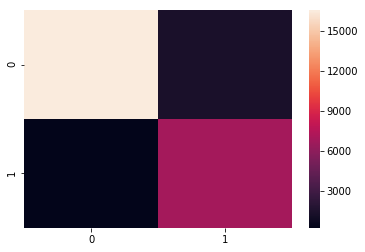

Learning Rate:[0.008145033635316127]
batch
batch
epoch219
train loss: 8.594674000050873e-06
Learning Rate:[0.009140576474687228]
batch
batch
epoch220
train loss: 8.574530511396006e-06
valid loss: 8.480579708702862e-06
accuracy: 93.73999834060669 %


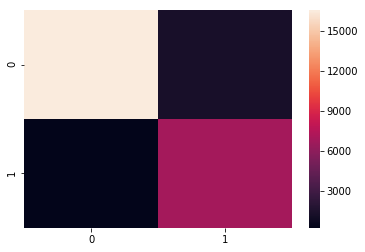

Learning Rate:[0.009779754323328196]
batch
batch
epoch221
train loss: 8.582301234127954e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch222
train loss: 8.532550964446273e-06
valid loss: 8.46186958369799e-06
accuracy: 93.76800060272217 %


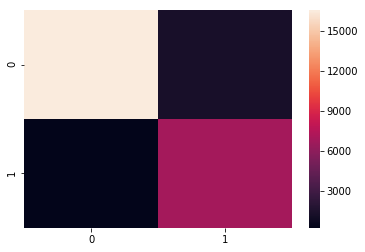

Learning Rate:[0.009779754323328182]
batch
batch
epoch223
train loss: 8.620955668448005e-06
Learning Rate:[0.00914057647468728]
batch
batch
epoch224
train loss: 8.50445849209791e-06
valid loss: 8.47724913910497e-06
accuracy: 93.85599493980408 %


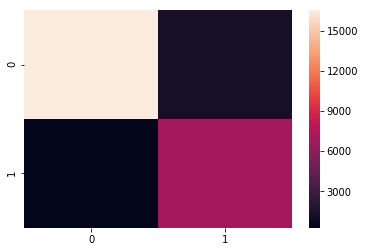

Learning Rate:[0.008145033635316146]
batch
batch
epoch225
train loss: 8.698159945197403e-06
Learning Rate:[0.006890576474687276]
batch
batch
epoch226
train loss: 8.485998478136025e-06
valid loss: 8.465553946734872e-06
accuracy: 93.75999569892883 %


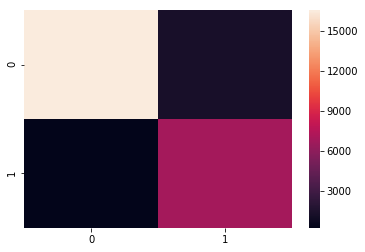

Learning Rate:[0.005500000000000005]
batch
batch
epoch227
train loss: 8.58573093864834e-06
Learning Rate:[0.0041094235253127335]
batch
batch
epoch228
train loss: 8.547111974621657e-06
valid loss: 8.474649803247303e-06
accuracy: 93.82799863815308 %


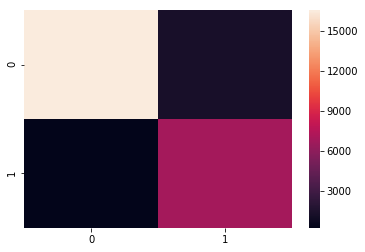

Learning Rate:[0.0028549663646839137]
batch
batch
epoch229
train loss: 8.47790033731144e-06
Learning Rate:[0.0018594235253127631]
batch
batch
epoch230
train loss: 8.480335964122787e-06
valid loss: 8.477266419504303e-06
accuracy: 93.81999969482422 %


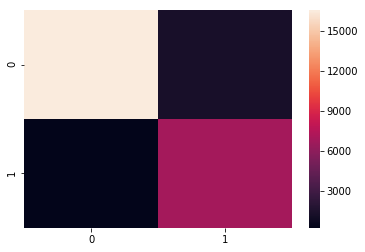

Learning Rate:[0.0012202456766718201]
batch
batch
epoch231
train loss: 8.49695334181888e-06
Learning Rate:[0.001]
batch
batch
epoch232
train loss: 8.53216988616623e-06
valid loss: 8.52101220516488e-06
accuracy: 93.88799667358398 %


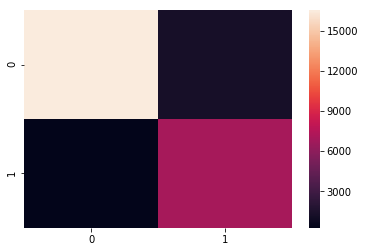

Learning Rate:[0.0012202456766718026]
batch
batch
epoch233
train loss: 8.55099642649293e-06
Learning Rate:[0.001859423525312729]
batch
batch
epoch234
train loss: 8.510441148246173e-06
valid loss: 8.481776603730395e-06
accuracy: 93.71999502182007 %


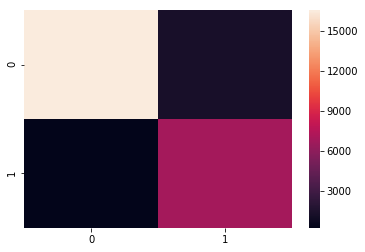

Learning Rate:[0.002854966364683867]
batch
batch
epoch235
train loss: 8.510622137691826e-06
Learning Rate:[0.00410942352531274]
batch
batch
epoch236
train loss: 8.618302672402933e-06
valid loss: 8.47721821628511e-06
accuracy: 93.77599954605103 %


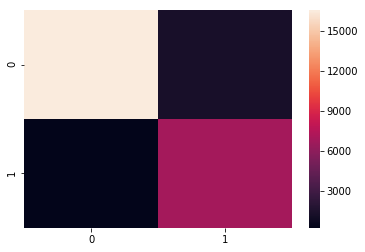

Learning Rate:[0.005500000000000012]
batch
batch
epoch237
train loss: 8.520754818164278e-06
Learning Rate:[0.006890576474687222]
batch
batch
epoch238
train loss: 8.581138899899088e-06
valid loss: 8.441034879069775e-06
accuracy: 93.6959981918335 %


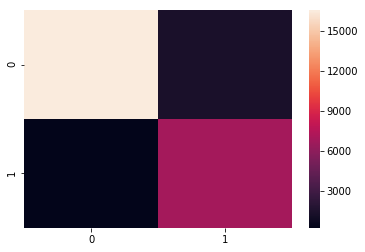

Learning Rate:[0.008145033635316101]
batch
batch
epoch239
train loss: 8.515799891029019e-06
Learning Rate:[0.009140576474687249]
batch
batch
epoch240
train loss: 8.543804142391309e-06
valid loss: 8.431776223005727e-06
accuracy: 93.69199872016907 %


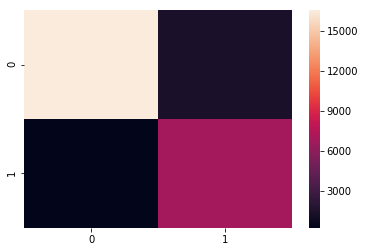

Learning Rate:[0.009779754323328185]
batch
batch
epoch241
train loss: 8.501607226207852e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch242
train loss: 8.569419151172042e-06
valid loss: 8.464798156637698e-06
accuracy: 93.65999698638916 %


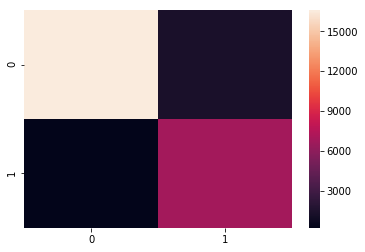

Learning Rate:[0.009779754323328196]
batch
batch
epoch243
train loss: 8.481377335556317e-06
Learning Rate:[0.009140576474687263]
batch
batch
epoch244
train loss: 8.621179404144641e-06
valid loss: 8.4861903815181e-06
accuracy: 93.63199472427368 %


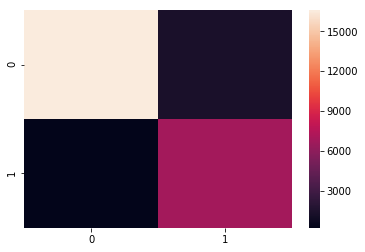

Learning Rate:[0.008145033635316122]
batch
batch
epoch245
train loss: 8.44546411826741e-06
Learning Rate:[0.006890576474687246]
batch
batch
epoch246
train loss: 8.737419193494134e-06
valid loss: 8.417640856350772e-06
accuracy: 93.7720000743866 %


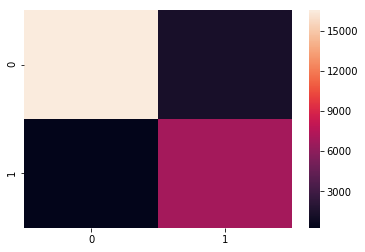

Learning Rate:[0.005500000000000039]
batch
batch
epoch247
train loss: 8.433866241830401e-06
Learning Rate:[0.004109423525312765]
batch
batch
epoch248
train loss: 8.456313480564859e-06
valid loss: 8.472102308587637e-06
accuracy: 93.92399787902832 %


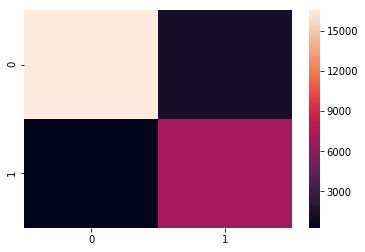

Learning Rate:[0.0028549663646838886]
batch
batch
epoch249
train loss: 8.554271516914014e-06
Learning Rate:[0.0018594235253127445]
batch
batch
epoch250
train loss: 8.492745109833777e-06
valid loss: 8.448889275314286e-06
accuracy: 93.86000037193298 %


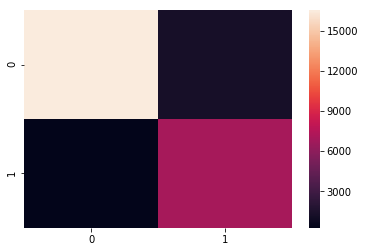

Learning Rate:[0.0012202456766718106]
batch
batch
epoch251
train loss: 8.443870683549903e-06
Learning Rate:[0.001]
batch
batch
epoch252
train loss: 8.439835255558137e-06
valid loss: 8.43625639390666e-06
accuracy: 93.79199743270874 %


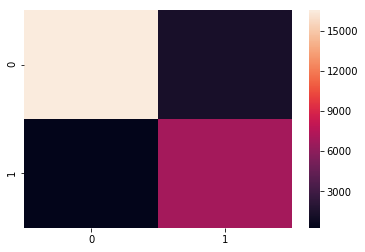

Learning Rate:[0.0012202456766718121]
batch
batch
epoch253
train loss: 8.463859558105469e-06
Learning Rate:[0.0018594235253127475]
batch
batch
epoch254
train loss: 8.545783202862367e-06
valid loss: 8.474572496197652e-06
accuracy: 93.86399984359741 %


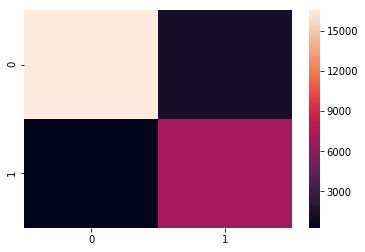

Learning Rate:[0.002854966364683892]
batch
batch
epoch255
train loss: 8.504573997925036e-06
Learning Rate:[0.004109423525312708]
batch
batch
epoch256
train loss: 8.473233719996642e-06
valid loss: 8.432380127487704e-06
accuracy: 93.74799728393555 %


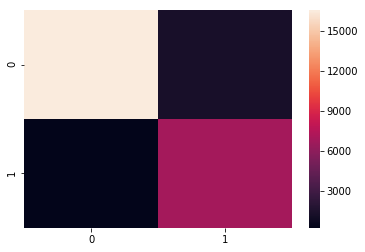

Learning Rate:[0.005499999999999979]
batch
batch
epoch257
train loss: 8.644629815535154e-06
Learning Rate:[0.00689057647468725]
batch
batch
epoch258
train loss: 8.430273737758398e-06
valid loss: 8.389735739910975e-06
accuracy: 93.79199743270874 %


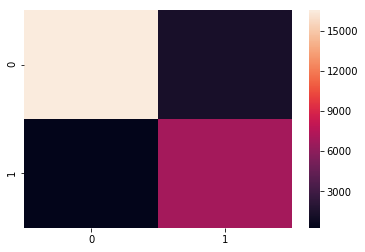

Learning Rate:[0.008145033635316126]
batch
batch
epoch259
train loss: 8.739179065742064e-06
Learning Rate:[0.009140576474687266]
batch
batch
epoch260
train loss: 8.450257155345753e-06
valid loss: 8.565491043555085e-06
accuracy: 94.2639946937561 %


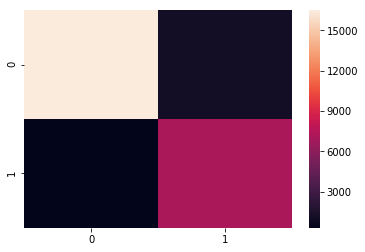

Learning Rate:[0.009779754323328175]
batch
batch
epoch261
train loss: 9.1073707153555e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch262
train loss: 9.521130778011866e-06
valid loss: 8.528118996764533e-06
accuracy: 94.14399862289429 %


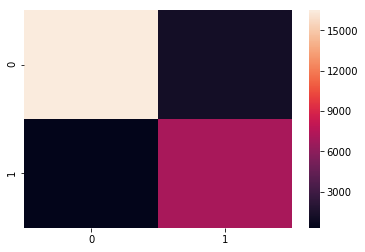

Learning Rate:[0.009779754323328206]
batch
batch
epoch263
train loss: 1.1648505278571974e-05
Learning Rate:[0.009140576474687245]
batch
batch
epoch264
train loss: 1.1689946404658258e-05
valid loss: 1.2064627298968844e-05
accuracy: 92.45599508285522 %


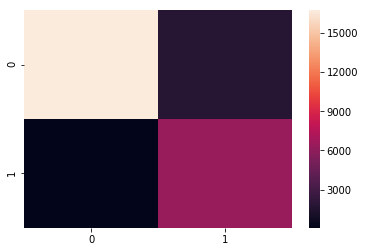

Learning Rate:[0.008145033635316148]
batch
batch
epoch265
train loss: 1.1051542969653383e-05
Learning Rate:[0.006890576474687278]
batch
batch
epoch266
train loss: 8.845388038025703e-06
valid loss: 1.0258582733513322e-05
accuracy: 92.94399619102478 %


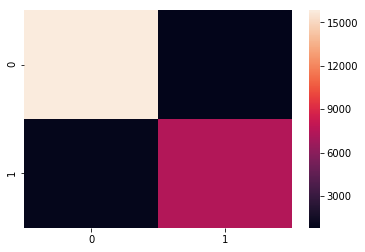

Learning Rate:[0.0055000000000000075]
batch
batch
epoch267
train loss: 1.063262334355386e-05
Learning Rate:[0.004109423525312735]
batch
batch
epoch268
train loss: 8.733420145290438e-06
valid loss: 9.023620805237442e-06
accuracy: 93.63600015640259 %


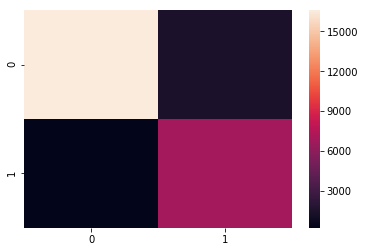

Learning Rate:[0.0028549663646838634]
batch
batch
epoch269
train loss: 9.210013558913488e-06
Learning Rate:[0.001859423525312764]
batch
batch
epoch270
train loss: 9.276425771531649e-06
valid loss: 9.166350537270773e-06
accuracy: 93.55599880218506 %


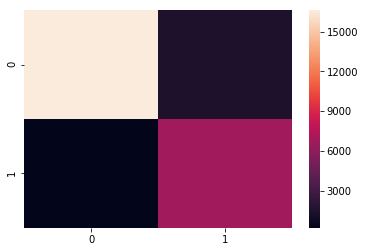

Learning Rate:[0.0012202456766718212]
batch
batch
epoch271
train loss: 9.066093298315536e-06
Learning Rate:[0.001]
batch
batch
epoch272
train loss: 8.831964805722237e-06
valid loss: 8.777193215792067e-06
accuracy: 93.86399984359741 %


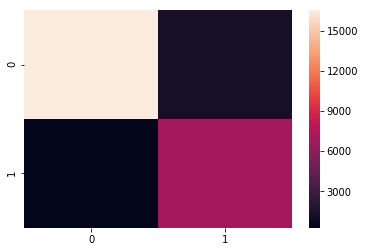

Learning Rate:[0.0012202456766718017]
batch
batch
epoch273
train loss: 8.914128557080403e-06
Learning Rate:[0.001859423525312728]
batch
batch
epoch274
train loss: 9.531299838272389e-06
valid loss: 9.355243491881993e-06
accuracy: 93.6519980430603 %


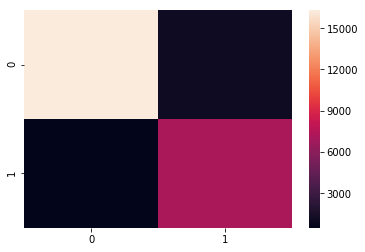

Learning Rate:[0.0028549663646838656]
batch
batch
epoch275
train loss: 9.083442819246557e-06
Learning Rate:[0.004109423525312738]
batch
batch
epoch276
train loss: 9.03074487723643e-06
valid loss: 9.2208438218222e-06
accuracy: 92.9319977760315 %


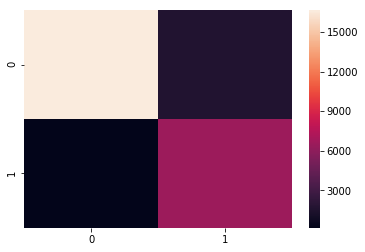

Learning Rate:[0.005500000000000009]
batch
batch
epoch277
train loss: 9.082864380616229e-06
Learning Rate:[0.006890576474687281]
batch
batch
epoch278
train loss: 9.810745723370928e-06
valid loss: 9.21067658055108e-06
accuracy: 93.56799721717834 %


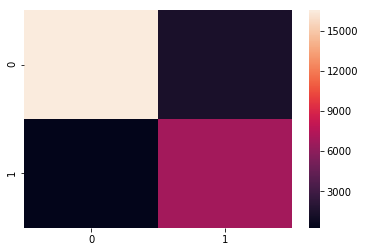

Learning Rate:[0.008145033635316098]
batch
batch
epoch279
train loss: 8.97247991815675e-06
Learning Rate:[0.009140576474687245]
batch
batch
epoch280
train loss: 8.892086952982936e-06
valid loss: 8.77410093380604e-06
accuracy: 93.46799850463867 %


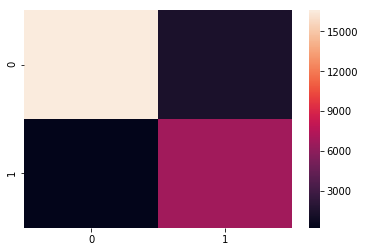

Learning Rate:[0.009779754323328185]
batch
batch
epoch281
train loss: 9.282646715291776e-06
Learning Rate:[0.010000000000000002]
batch
batch
epoch282
train loss: 8.616144441475626e-06
valid loss: 8.6463460320374e-06
accuracy: 93.59599947929382 %


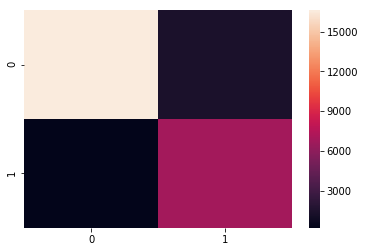

Learning Rate:[0.009779754323328196]
batch
batch
epoch283
train loss: 8.566932592657395e-06
Learning Rate:[0.0091405764746873]
batch
batch
epoch284
train loss: 8.71504107635701e-06
valid loss: 8.5150204540696e-06
accuracy: 93.7279999256134 %


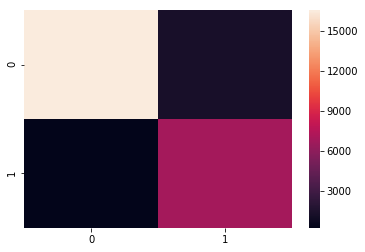

Learning Rate:[0.008145033635316122]
batch
batch
epoch285
train loss: 8.546417120669503e-06
Learning Rate:[0.0068905764746872485]
batch
batch
epoch286
train loss: 8.55925100040622e-06
valid loss: 8.569992132834159e-06
accuracy: 93.73199939727783 %


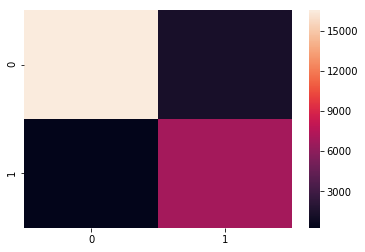

Learning Rate:[0.005499999999999976]
batch
batch
epoch287
train loss: 8.690411959833e-06
Learning Rate:[0.0041094235253127664]
batch
batch
epoch288
train loss: 8.63896457303781e-06
valid loss: 8.581552719988395e-06
accuracy: 93.6519980430603 %


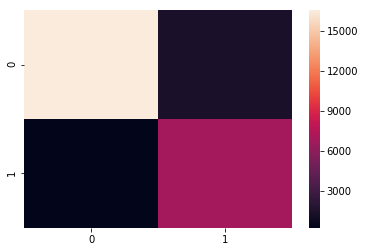

Learning Rate:[0.0028549663646838903]
batch
batch
epoch289
train loss: 8.579951099818572e-06
Learning Rate:[0.0018594235253127462]
batch
batch
epoch290
train loss: 8.57628219819162e-06
valid loss: 8.573187187721487e-06
accuracy: 93.55999827384949 %


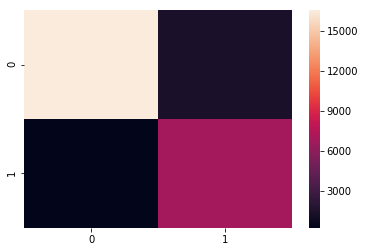

Learning Rate:[0.0012202456766718117]
batch
batch
epoch291
train loss: 8.580151188652962e-06
Learning Rate:[0.001]
batch
batch
epoch292
train loss: 8.595433428126853e-06
valid loss: 8.595012332079932e-06
accuracy: 93.66399645805359 %


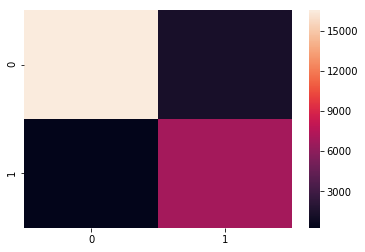

Learning Rate:[0.0012202456766717917]
batch
batch
epoch293
train loss: 8.630451702629216e-06
Learning Rate:[0.0018594235253127085]
batch
batch
epoch294
train loss: 8.639111001684796e-06
valid loss: 8.581575457355939e-06
accuracy: 93.69999766349792 %


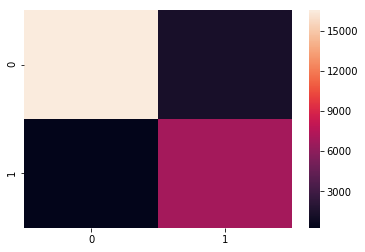

Learning Rate:[0.0028549663646838387]
batch
batch
epoch295
train loss: 8.571696525905281e-06
Learning Rate:[0.0041094235253127664]
batch
batch
epoch296
train loss: 8.541643182979897e-06
valid loss: 8.51502591103781e-06
accuracy: 93.66799592971802 %


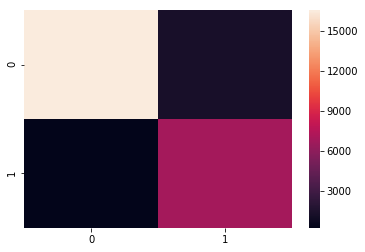

Learning Rate:[0.005499999999999976]
batch
batch
epoch297
train loss: 8.583830094721634e-06
Learning Rate:[0.0068905764746872485]
batch
batch
epoch298
train loss: 8.536290806659963e-06
valid loss: 8.470177817798685e-06
accuracy: 93.68000030517578 %


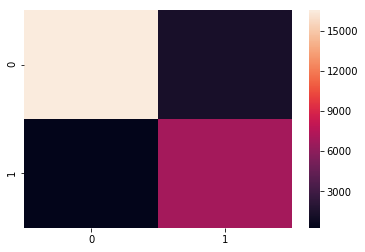

Learning Rate:[0.008145033635316122]
batch
batch
epoch299
train loss: 8.489424544677604e-06
Learning Rate:[0.009140576474687266]


In [30]:
# Training Loop 

highest = 0
for k in range(300):
    running_loss= 0 
    corrects = 0
    #Train
    for inp, target in Train:
        optimizer.zero_grad()
        inp = inp.cuda()
        print('batch')
        output = model.forward(inp.float())
        loss = nn.functional.binary_cross_entropy(output, target.float().cuda()) 
        #loss = CrossEntropy(output, target.float().reshape(output.shape).cuda())
        loss.backward()
        optimizer.step()
        running_loss += loss/len(target)  
    if k % 1==0: 
        print("epoch{}".format(k))
        print("train loss: {}".format(running_loss))    
    running_loss= 0 
    # Added the option of just running the Training step for the first few epochs.
    if k > 1:
        # Validate. 
        for inp, target in Valid:
            inp = inp.cuda()
            output = model.forward(inp.float())
            loss = nn.functional.binary_cross_entropy(output, target.float().reshape(output.shape).cuda()) 
            #Track Epoch Loss
            running_loss += loss/len(target)
            a = (output>0.5) 
            b= target.reshape(output.shape).cuda()>0.5 
        
        #Print out. 
        if k % 2 ==0: 
            print("valid loss: {}".format(running_loss))
            print("accuracy: {} %".format((a==b).float().mean().item()*100))
            if ((a==b).float().mean().item()*100)> highest:
                highest = ((a==b).float().mean().item()*100)
                #Save out model that achieves best accuracy. 
                torch.save(model.state_dict(), './ModelSave3.pt')
                print("saved")
            sns.heatmap(confusion_matrix(a.cpu().numpy(),b.cpu().numpy()))
            plt.show()
            
    print("Learning Rate:{}".format(scheduler.get_lr()))
    scheduler.step() 

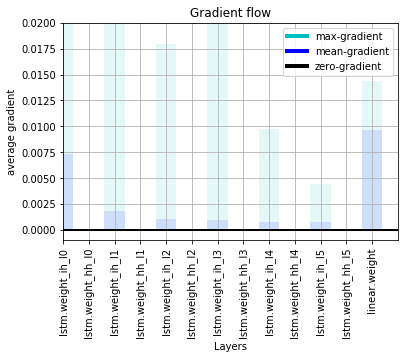

In [31]:
from matplotlib.lines import Line2D   
def plot_grad_flow(named_parameters):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
plot_grad_flow(model.named_parameters())

In [74]:
inp.unsqueeze(0).permute([1,0,2]).shape

torch.Size([200000, 1, 6])

In [23]:
named_parameters = model.named_parameters()
ave_grads = []
layers = []
for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())

AttributeError: 'NoneType' object has no attribute 'abs'

In [24]:
type(p)
n

'layer2.weight'

model.named_parameters


# Evaluate Model
 Load up the best performing model. Run the model and Plot the results. 

In [32]:
model2 = Classifier(6, 6, batch_size=BatchSize, output_dim=1, num_layers=10)
model2.load_state_dict(torch.load('./ModelSave3.pt'))
model2.cuda()

df = pd.read_pickle("Reduced.pkl")
df3 = pd.read_pickle("Reduced3.pkl")
df = df.append(df3)
df = df.append(df4.drop('time',axis=1),sort=True)
#Load into Torch Dataset. 
Input = torch.tensor(InpScaler.transform(df[LabelList].values))
Output = torch.tensor(df['Labels'].values)

MainDataSet = torch.utils.data.TensorDataset(Input, Output)
Main = torch.utils.data.DataLoader(MainDataSet,batch_size = 200000,num_workers = 1)
full_results = torch.Tensor()
#Run Model over the batches. 
for inp, Label in Main:
    inp = inp.cuda()
    output = model2.forward(inp.float())
    
    third_tensor = torch.cat((inp.cpu().float(),output.cpu().float()), 1)
    third_tensor = torch.cat((third_tensor,Label.reshape(output.shape).float()), 1)
    full_results = torch.cat((full_results,third_tensor),0)

RuntimeError: Error(s) in loading state_dict for Classifier:
	Missing key(s) in state_dict: "lstm.weight_ih_l6", "lstm.weight_hh_l6", "lstm.bias_ih_l6", "lstm.bias_hh_l6", "lstm.weight_ih_l7", "lstm.weight_hh_l7", "lstm.bias_ih_l7", "lstm.bias_hh_l7", "lstm.weight_ih_l8", "lstm.weight_hh_l8", "lstm.bias_ih_l8", "lstm.bias_hh_l8", "lstm.weight_ih_l9", "lstm.weight_hh_l9", "lstm.bias_ih_l9", "lstm.bias_hh_l9". 

<IPython.core.display.Javascript object>


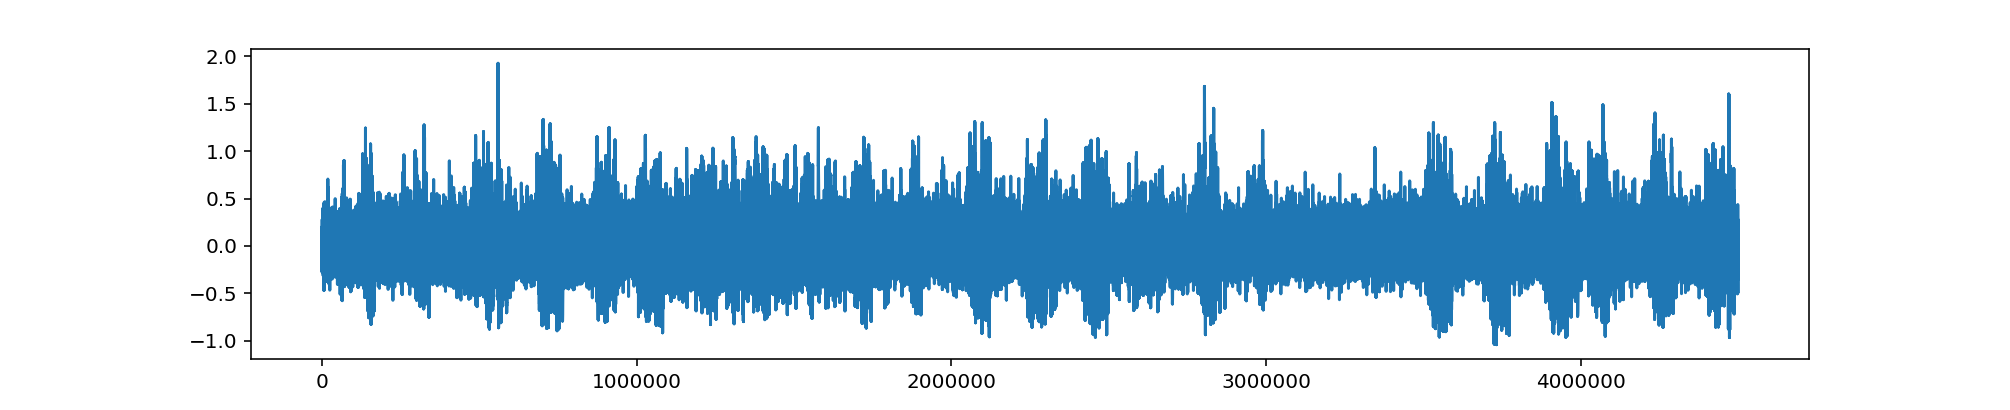

In [28]:
plt.figure()
df.ts.plot()
plt.show()

<IPython.core.display.Javascript object>


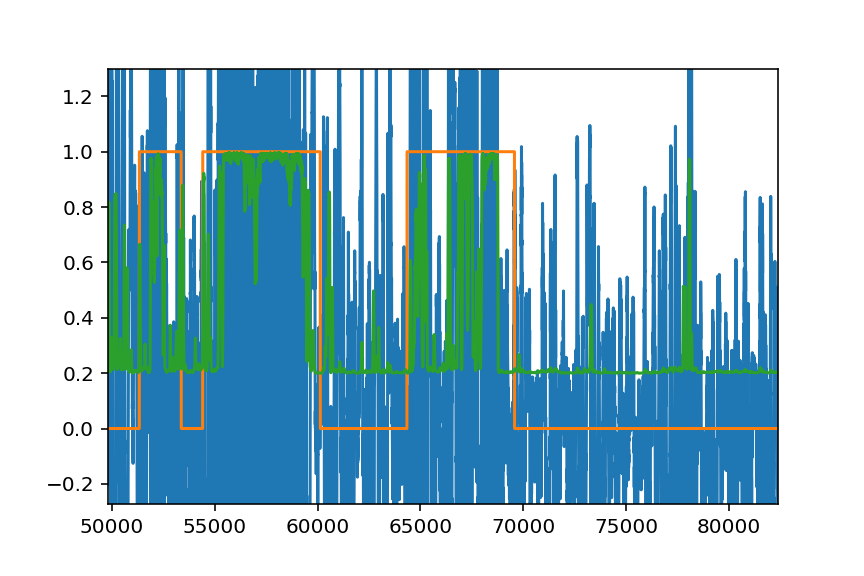

In [22]:
%matplotlib notebook
third_tensor.detach().numpy()
plt.plot(third_tensor[:,0].detach().numpy())
plt.plot(third_tensor[:,-1].detach().numpy())         
plt.plot(third_tensor[:,-2].detach().numpy()) 
plt.show()

<IPython.core.display.Javascript object>


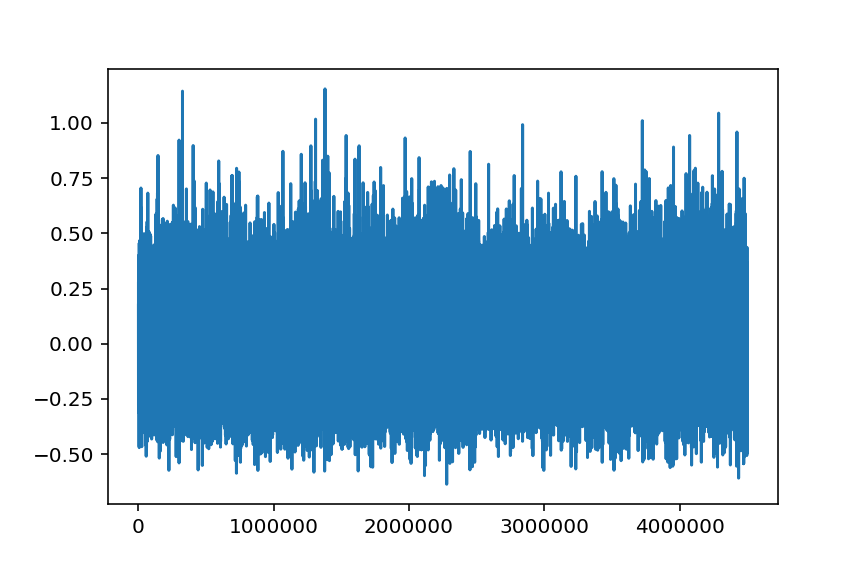

In [27]:
plt.figure()
df4.ts.plot()
plt.show()

In [ ]:
#Confusion Plot. 
plt.figure()

full_results[:,-2] = full_results[:,-2]>0.5
sns.heatmap(confusion_matrix(full_results[:,-2].detach().numpy(),full_results[:,-1].detach().numpy()))
plt.show()

In [ ]:
#Time Series
plt.figure()
plt.plot(full_results[:,0].detach().numpy())
plt.plot(full_results[:,-1].detach().numpy())
plt.plot(full_results[:,-2].detach().numpy())
plt.show()